In [7]:
pip install aiomoex

In [8]:
pip install dateparser

In [9]:
from typing import List
from abc import abstractmethod, ABC
import os.path

from datetime import date
from pathlib import Path
import shutil
import aiohttp
import aiomoex
import asyncio
import pandas as pd
from aiomoex import client
from aiomoex.request_helpers import make_url, get_table, make_query
import requests
import dateparser
from pydantic import BaseModel
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import norm

from tqdm import tqdm

In [10]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/MyDrive/homeworks/ФТИАД/Риски/risk_data.xlsx')
df = df.drop('Unnamed: 0', axis=1)

Mounted at /content/drive


## стата

In [11]:
def risks_info(ser):

    a = ser
    a.index = df['TRADEDATE']
    print(f'mean value of {a.name}: {a.mean()}')
    print(f'std value of {a.name}: {a.std()}')
    print(f'max value of {a.name}: {a.max()}')
    print(f'min value of {a.name}: {a.min()}')
    p_val = sm.tsa.stattools.adfuller(a)[1]
    print("Критерий Дики-Фуллера: p_value = %f" % sm.tsa.stattools.adfuller(a)[1])
    if p_val > 0.05:
        print(f'Ряд {a.name} не стационарен')
    else:
        print(f'Ряд {a.name} стационарен')
    fig = go.Figure()

    fig.add_trace(go.Scatter(y=a, x=a.index, name=f'{a.name}'))

    fig.update_layout(
       title_text=f'{a.name} Trend and Values',
       xaxis_title_text='дата',
       yaxis_title_text='значение'
    )

    window_size = 90
    rolling_mean = a.rolling\
                (window_size).mean()


    fig.add_trace(go.Scatter(y=rolling_mean.values, x=rolling_mean.index, name=f'{a.name} Trend'))

    fig.update_layout(
       xaxis_title_text='date',
       yaxis_title_text='val'
    )

    fig.show()



    stats.probplot(a, dist="norm", plot=plt)
    plt.title(f'QQ plot for {a.name}')
    plt.xlabel('Theor quant')
    plt.ylabel('ordered vals')
    plt.show()

    ax = plt.subplot(1, 1, 1)
    sns.distplot(a, hist=True, kde=True,
                 bins=int(180/5), color = 'darkblue',
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4}, ax=ax)

    plt.show()

In [12]:
df_data_info = {
    'stocks': ['SBER', 'GAZP', 'PLZL', 'GMKN', 'MAGN',
       'POLY', 'YNDX', 'ALRS', 'MVID', 'AFKS'],
    'currency': ['EUR', 'USD'],
    'bonds': ['SU26215RMFS2', 'SU26207RMFS9', 'SU26212RMFS9',
       'SU26211RMFS1', 'SU29009RMFS6'],
    'indexes': ['RTSI', 'IMOEX'],
    'zero_couponse': ['period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0',
       'period_3.0', 'period_5.0', 'period_7.0', 'period_10.0', 'period_15.0',
       'period_20.0', 'period_30.0'],
    'brend': ['ICE.BRN'],
    'other': ['Ключевая ставка','Инфляция','Ставка', 'TRADEDATE'],
    'risks': ['TRADEDATE', 'Ключевая ставка','Инфляция','Ставка',
            'Gold','ICE.BRN','period_0.25','period_0.5','period_0.75','period_1.0',
            'period_2.0','period_3.0', 'period_5.0', 'period_7.0', 'period_10.0',
           'period_15.0', 'period_20.0', 'period_30.0','IMOEX', 'RTSI']
}


print(df_data_info)

{'stocks': ['SBER', 'GAZP', 'PLZL', 'GMKN', 'MAGN', 'POLY', 'YNDX', 'ALRS', 'MVID', 'AFKS'], 'currency': ['EUR', 'USD'], 'bonds': ['SU26215RMFS2', 'SU26207RMFS9', 'SU26212RMFS9', 'SU26211RMFS1', 'SU29009RMFS6'], 'indexes': ['RTSI', 'IMOEX'], 'zero_couponse': ['period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0', 'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0'], 'brend': ['ICE.BRN'], 'other': ['Ключевая ставка', 'Инфляция', 'Ставка', 'TRADEDATE'], 'risks': ['TRADEDATE', 'Ключевая ставка', 'Инфляция', 'Ставка', 'Gold', 'ICE.BRN', 'period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0', 'period_10.0', 'period_15.0', 'period_20.0', 'period_30.0', 'IMOEX', 'RTSI']}


In [13]:
df.columns

Index(['TRADEDATE', 'Ключевая ставка', 'Инфляция', 'Ставка', 'Gold', 'ICE.BRN',
       'period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 'period_2.0',
       'period_3.0', 'period_5.0', 'period_7.0', 'period_10.0', 'period_15.0',
       'period_20.0', 'period_30.0', 'SBER', 'GAZP', 'PLZL', 'GMKN', 'MAGN',
       'POLY', 'YNDX', 'ALRS', 'MVID', 'AFKS', 'EUR_RUB__TOD', 'EUR', 'RTSI',
       'IMOEX', 'SU26215RMFS2', 'SU26207RMFS9', 'SU26212RMFS9', 'SU26211RMFS1',
       'SU29009RMFS6', 'USD'],
      dtype='object')

# Часть 2

In [14]:
#выделяем риск-факторы

risks = df[df_data_info['risks']]

<ipython-input-15-ad56920675cd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(risks.corr(), annot=True)


<Axes: >

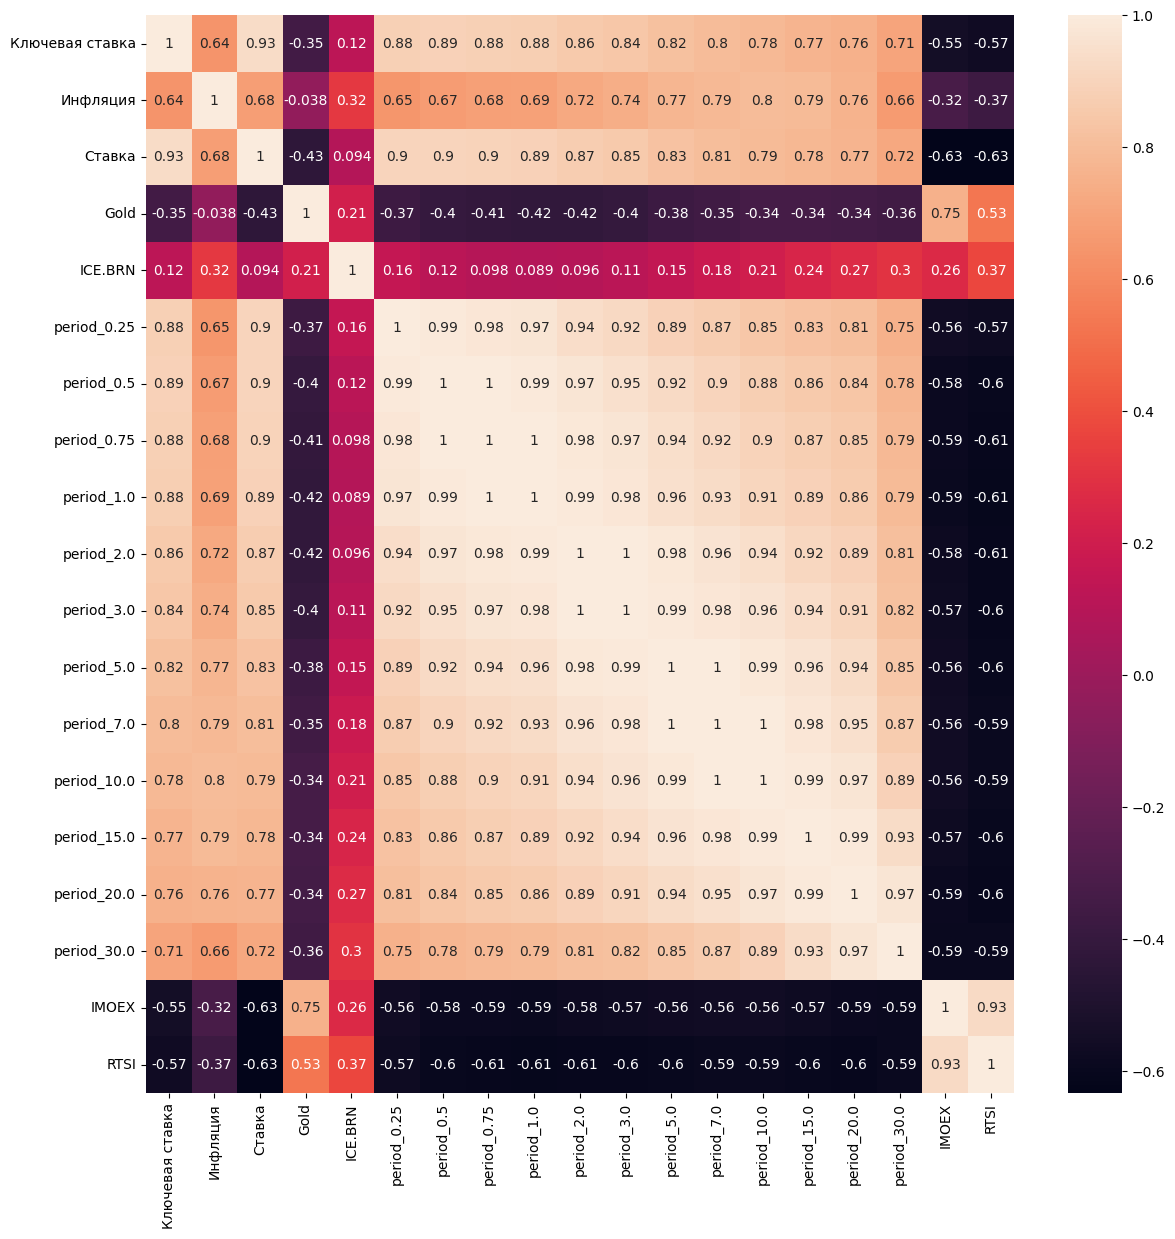

In [15]:
fig = plt.figure(figsize=(14, 14))
sns.heatmap(risks.corr(), annot=True)

mean value of Ключевая ставка: 8.495793606281548
std value of Ключевая ставка: 2.9686386592787373
max value of Ключевая ставка: 20.0
min value of Ключевая ставка: 4.25
Критерий Дики-Фуллера: p_value = 0.014684
Ряд Ключевая ставка стационарен


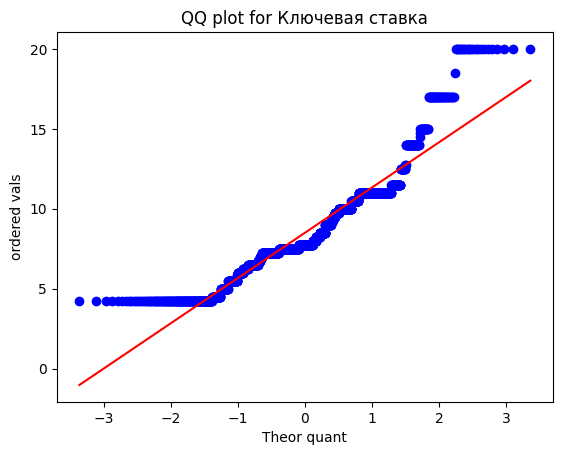

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




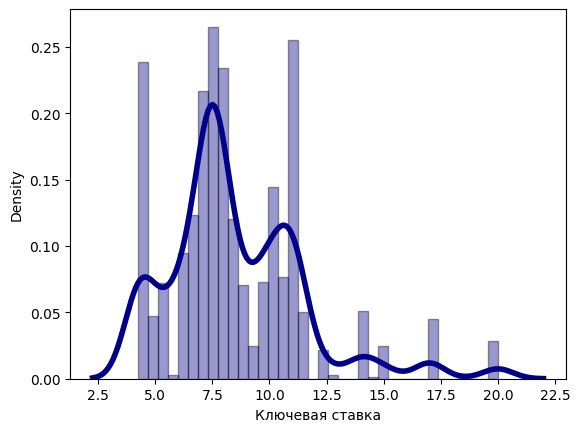

mean value of Инфляция: 7.137285473920358
std value of Инфляция: 4.691381880807378
max value of Инфляция: 17.83
min value of Инфляция: 2.2
Критерий Дики-Фуллера: p_value = 0.132284
Ряд Инфляция не стационарен


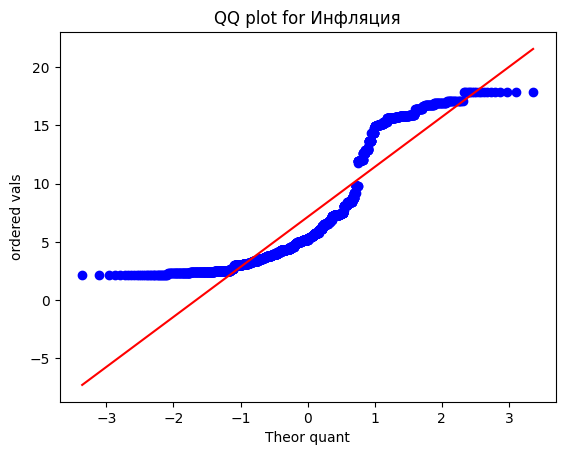

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




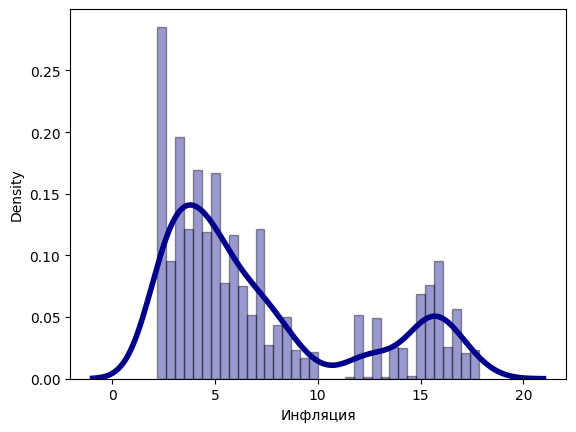

mean value of Ставка: 8.465227145260796
std value of Ставка: 2.8347998614033085
max value of Ставка: 20.0
min value of Ставка: 4.25
Критерий Дики-Фуллера: p_value = 0.048053
Ряд Ставка стационарен


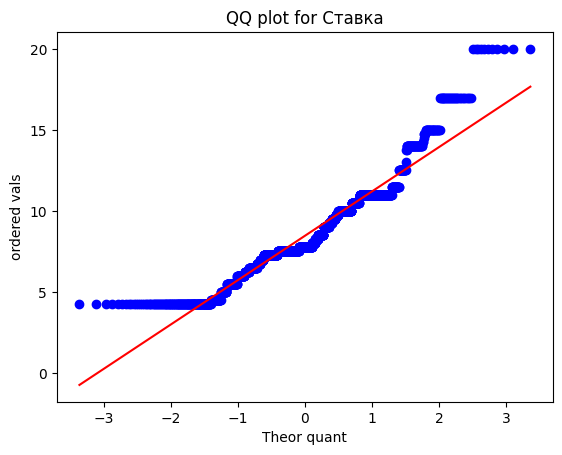

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




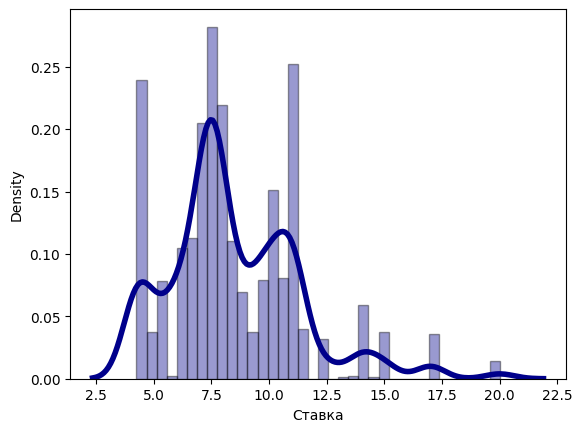

mean value of Gold: 3123.7006281547956
std value of Gold: 838.0652503978821
max value of Gold: 6408.41
min value of Gold: 1900.02
Критерий Дики-Фуллера: p_value = 0.688105
Ряд Gold не стационарен


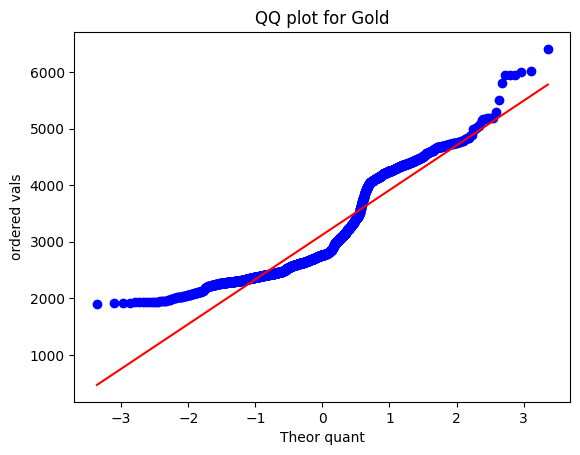

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




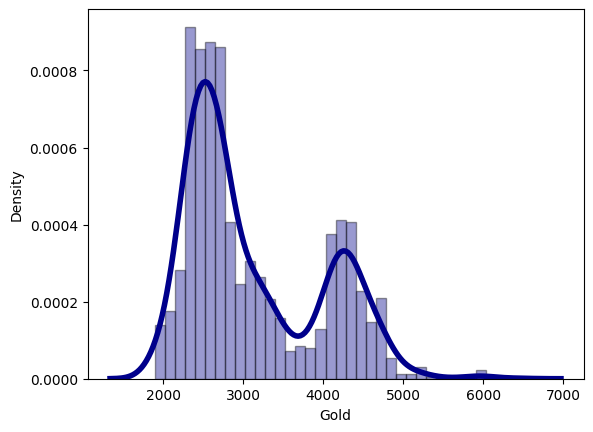

mean value of ICE.BRN: 62.47220975883342
std value of ICE.BRN: 18.12570242523796
max value of ICE.BRN: 122.93
min value of ICE.BRN: 19.5
Критерий Дики-Фуллера: p_value = 0.502324
Ряд ICE.BRN не стационарен


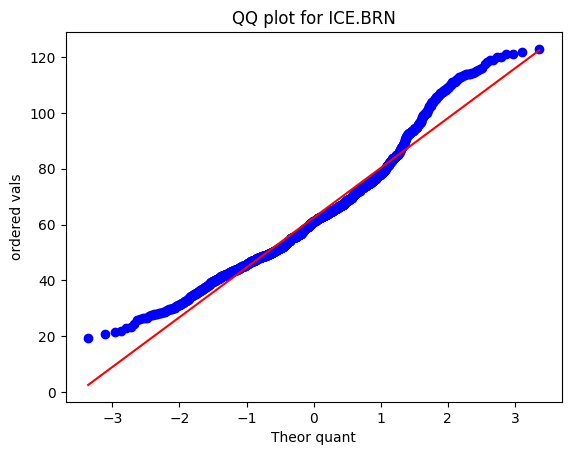

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




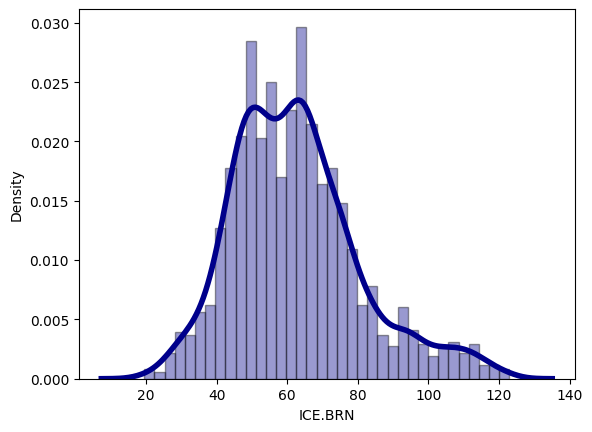

mean value of period_0.25: 7.742518227706113
std value of period_0.25: 2.339437469334871
max value of period_0.25: 17.87
min value of period_0.25: 3.68
Критерий Дики-Фуллера: p_value = 0.153869
Ряд period_0.25 не стационарен


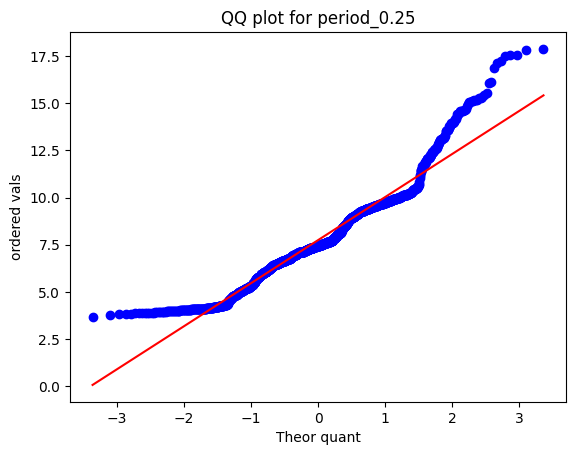

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




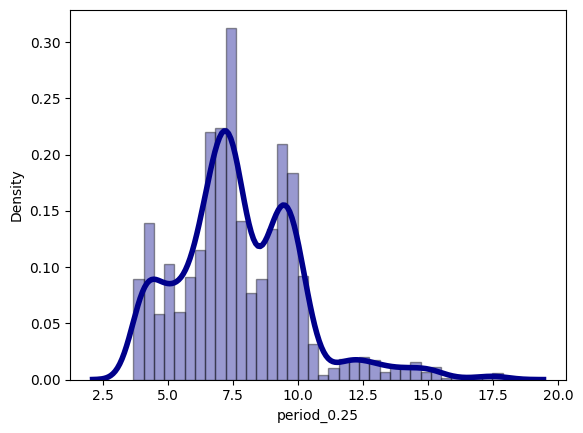

mean value of period_0.5: 7.7829220415030855
std value of period_0.5: 2.2853777959290604
max value of period_0.5: 17.29
min value of period_0.5: 3.87
Критерий Дики-Фуллера: p_value = 0.071058
Ряд period_0.5 не стационарен


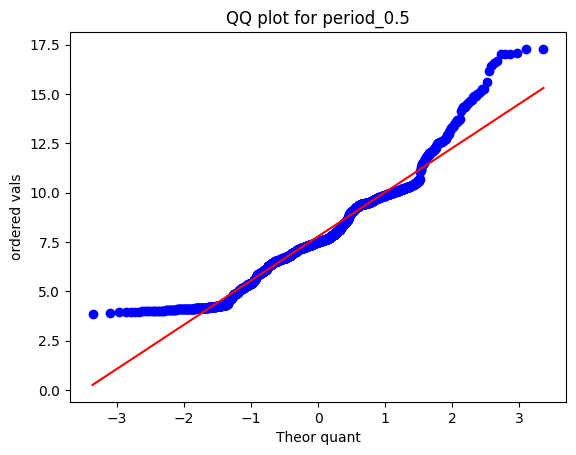

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




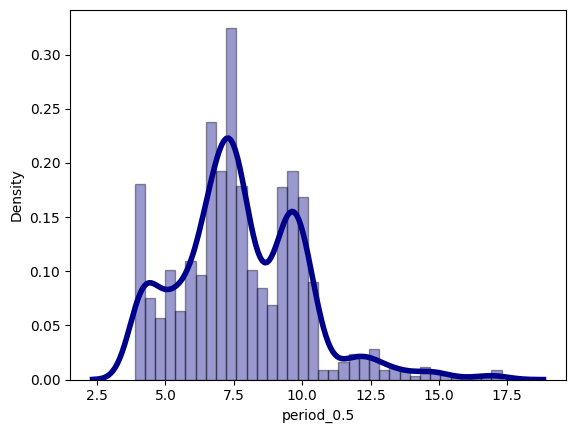

mean value of period_0.75: 7.8151037577117215
std value of period_0.75: 2.25364555093536
max value of period_0.75: 16.85
min value of period_0.75: 4.02
Критерий Дики-Фуллера: p_value = 0.015107
Ряд period_0.75 стационарен


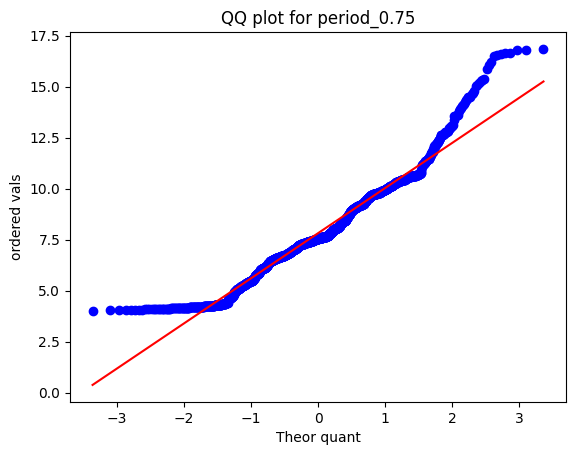

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




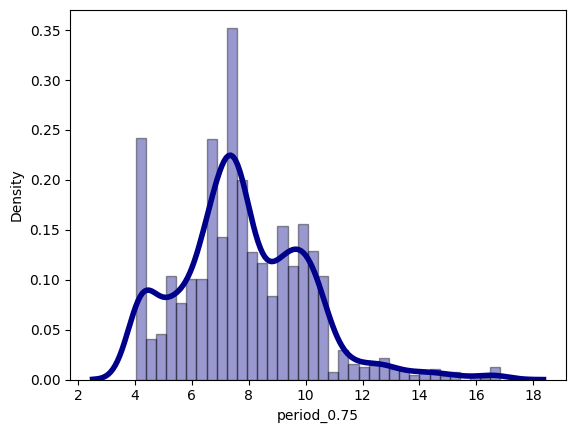

mean value of period_1.0: 7.84431856421761
std value of period_1.0: 2.2284359524300417
max value of period_1.0: 16.86
min value of period_1.0: 4.11
Критерий Дики-Фуллера: p_value = 0.010820
Ряд period_1.0 стационарен


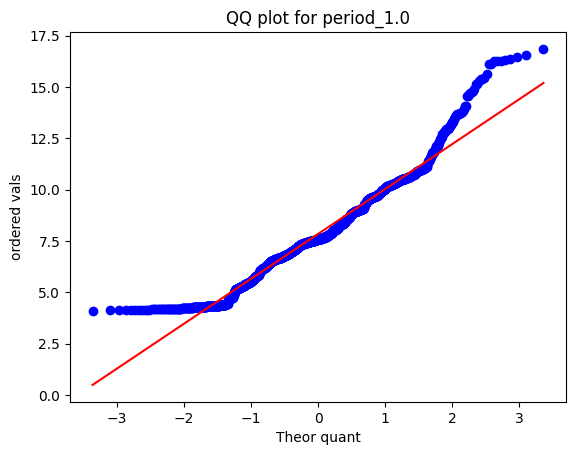

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




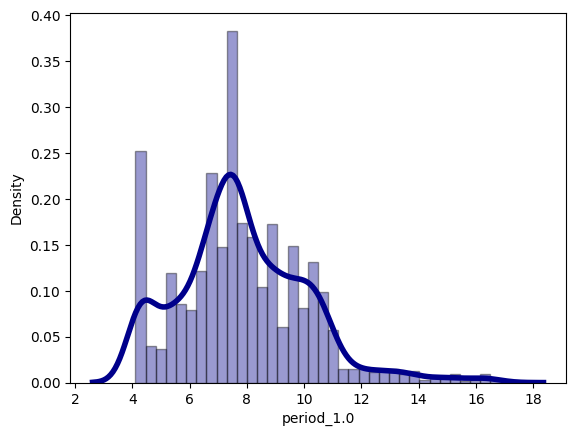

mean value of period_2.0: 7.953802579921481
std value of period_2.0: 2.1442456099932636
max value of period_2.0: 17.42
min value of period_2.0: 4.38
Критерий Дики-Фуллера: p_value = 0.004440
Ряд period_2.0 стационарен


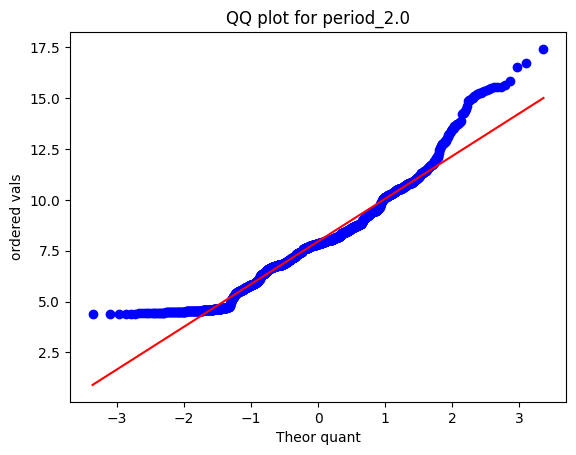

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




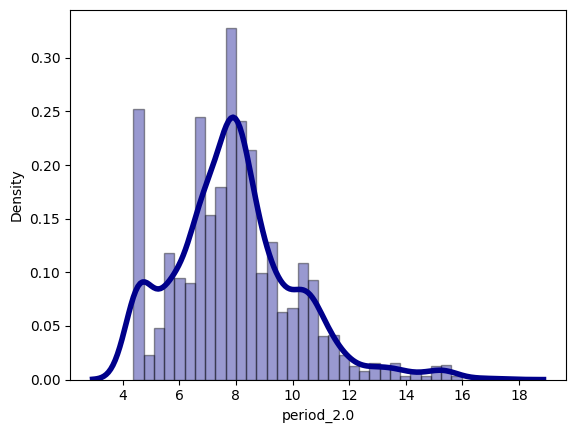

mean value of period_3.0: 8.047005047672464
std value of period_3.0: 2.066085126031941
max value of period_3.0: 17.57
min value of period_3.0: 4.6
Критерий Дики-Фуллера: p_value = 0.002691
Ряд period_3.0 стационарен


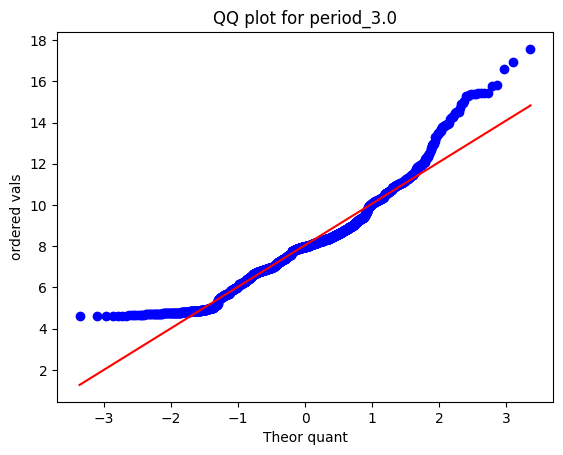

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




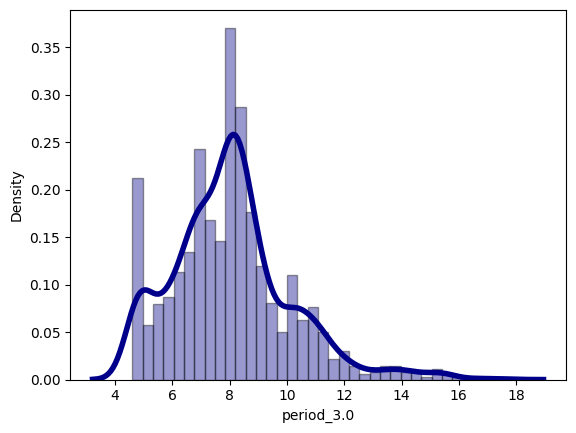

mean value of period_5.0: 8.183920358945597
std value of period_5.0: 1.9191514703818409
max value of period_5.0: 17.22
min value of period_5.0: 4.95
Критерий Дики-Фуллера: p_value = 0.003677
Ряд period_5.0 стационарен


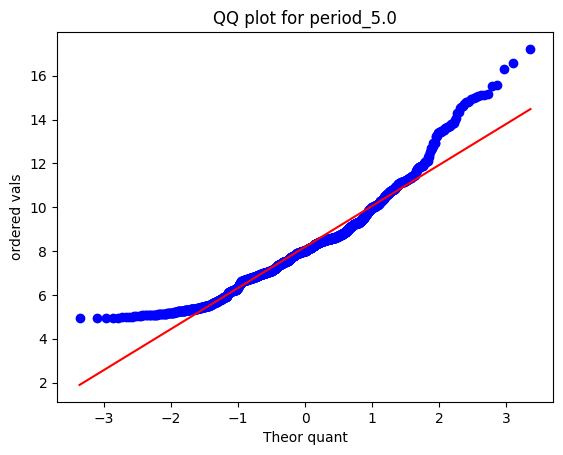

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




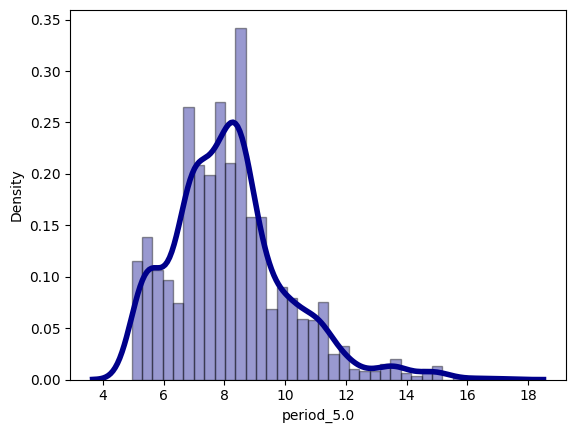

mean value of period_7.0: 8.27421200224341
std value of period_7.0: 1.787687919197299
max value of period_7.0: 16.39
min value of period_7.0: 5.22
Критерий Дики-Фуллера: p_value = 0.012115
Ряд period_7.0 стационарен


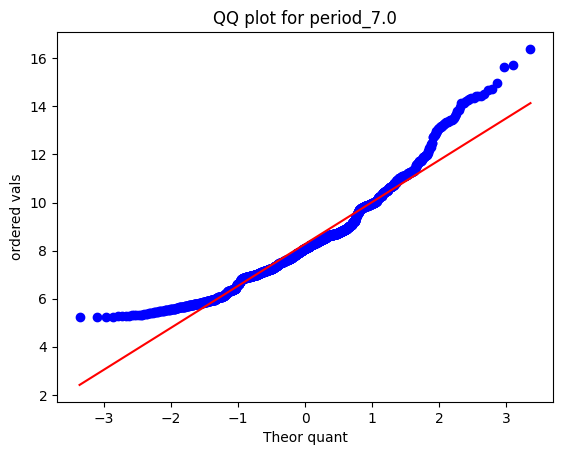

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




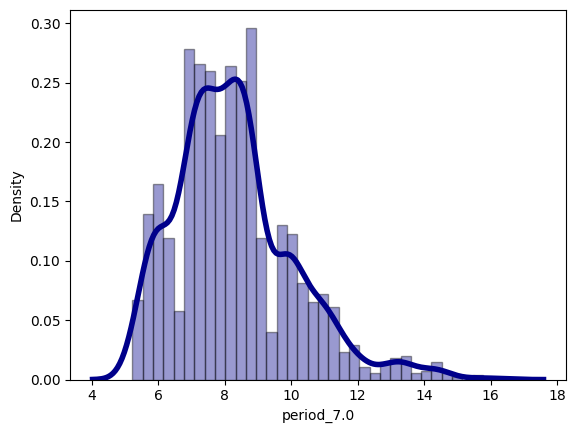

mean value of period_10.0: 8.36399326977005
std value of period_10.0: 1.6194897022141186
max value of period_10.0: 14.98
min value of period_10.0: 5.59
Критерий Дики-Фуллера: p_value = 0.040727
Ряд period_10.0 стационарен


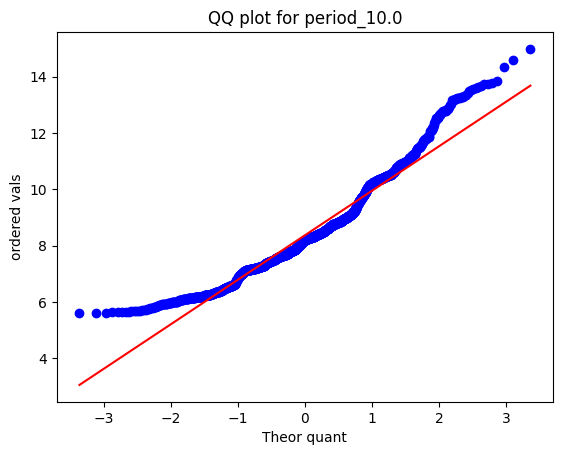

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




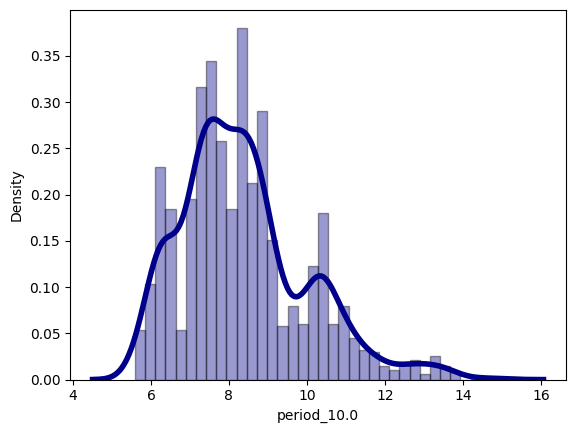

mean value of period_15.0: 8.456651710600111
std value of period_15.0: 1.416565833351961
max value of period_15.0: 13.47
min value of period_15.0: 5.97
Критерий Дики-Фуллера: p_value = 0.143497
Ряд period_15.0 не стационарен


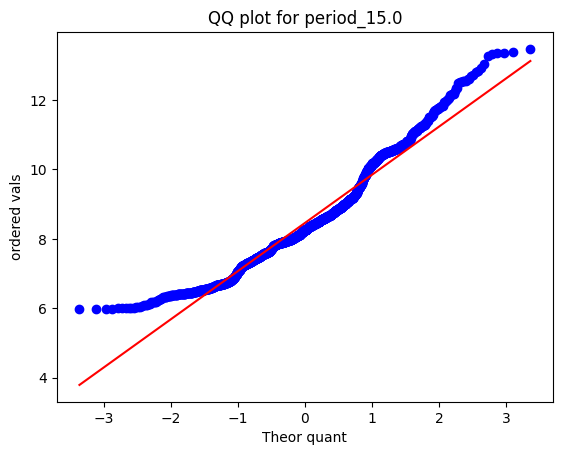

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




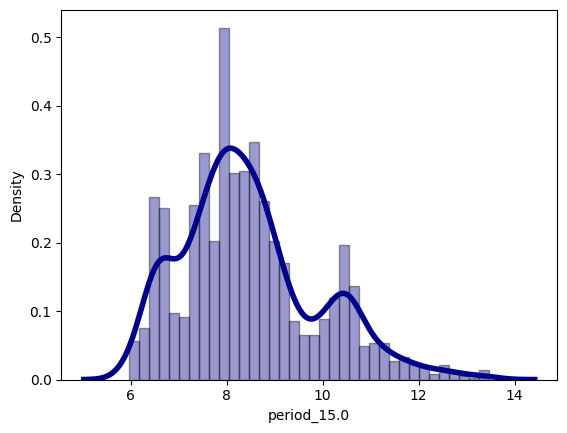

mean value of period_20.0: 8.517706113292205
std value of period_20.0: 1.2850565888668062
max value of period_20.0: 13.49
min value of period_20.0: 6.17
Критерий Дики-Фуллера: p_value = 0.260817
Ряд period_20.0 не стационарен


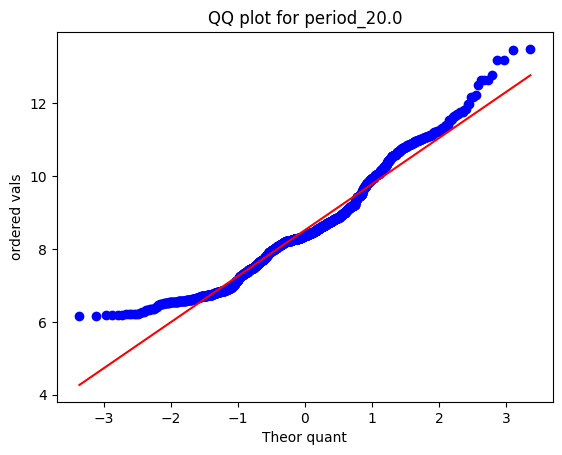

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




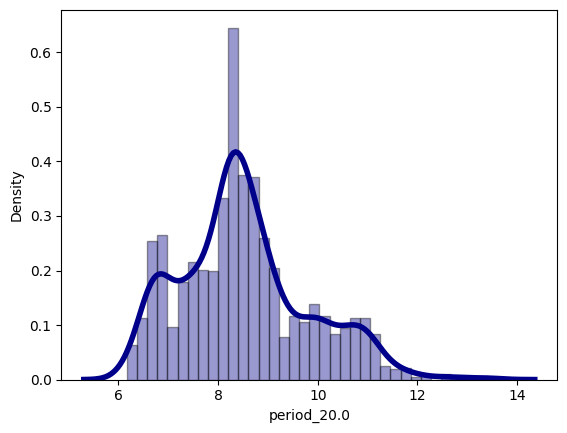

mean value of period_30.0: 8.602725743129557
std value of period_30.0: 1.1625002450763993
max value of period_30.0: 13.61
min value of period_30.0: 6.37
Критерий Дики-Фуллера: p_value = 0.401099
Ряд period_30.0 не стационарен


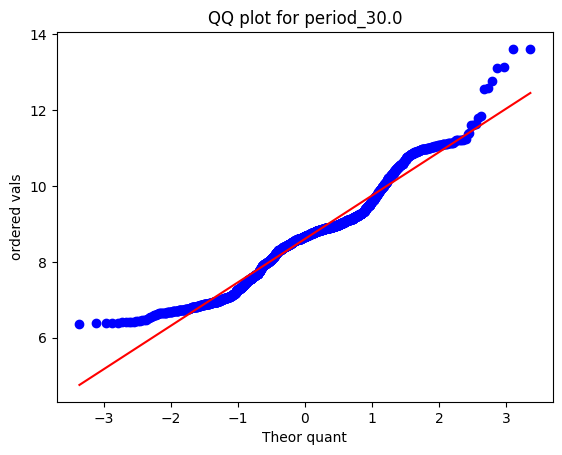

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




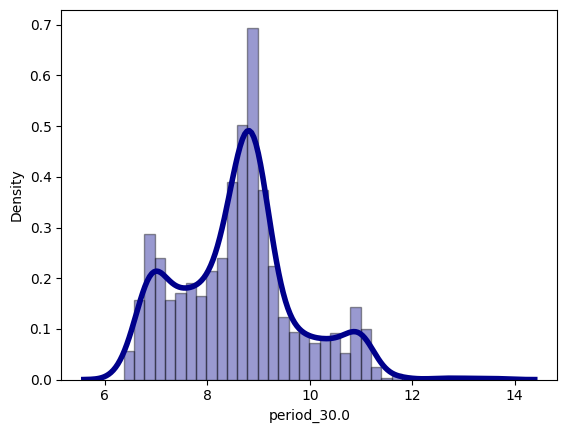

mean value of IMOEX: 2470.0811693774535
std value of IMOEX: 655.8511628757299
max value of IMOEX: 4287.52
min value of IMOEX: 1480.73
Критерий Дики-Фуллера: p_value = 0.523099
Ряд IMOEX не стационарен


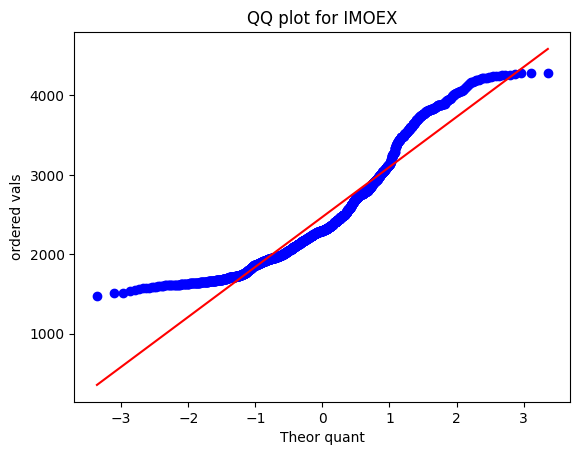

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




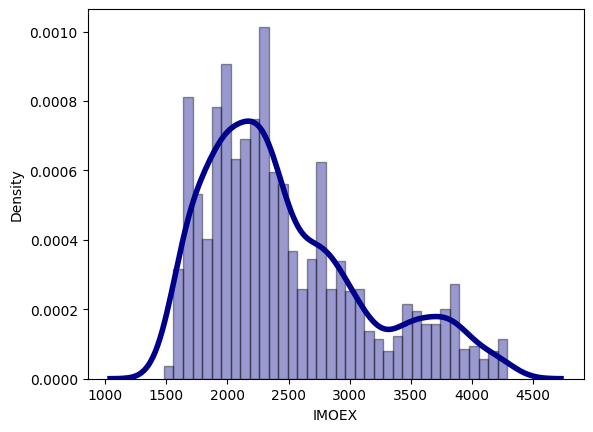

mean value of RTSI: 1176.4285445877733
std value of RTSI: 248.5088467117872
max value of RTSI: 1919.58
min value of RTSI: 628.41
Критерий Дики-Фуллера: p_value = 0.126327
Ряд RTSI не стационарен


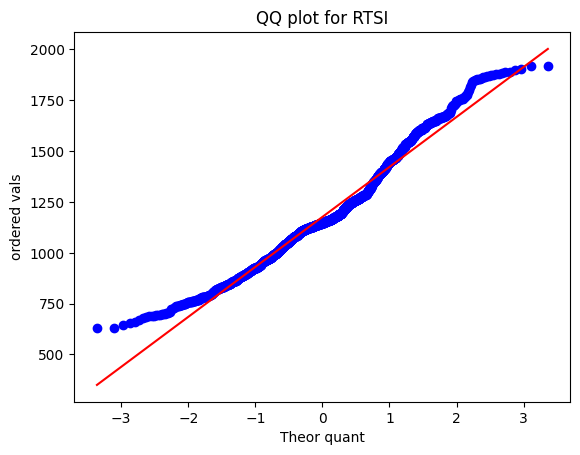

<ipython-input-11-7ae95d635af2>:48: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




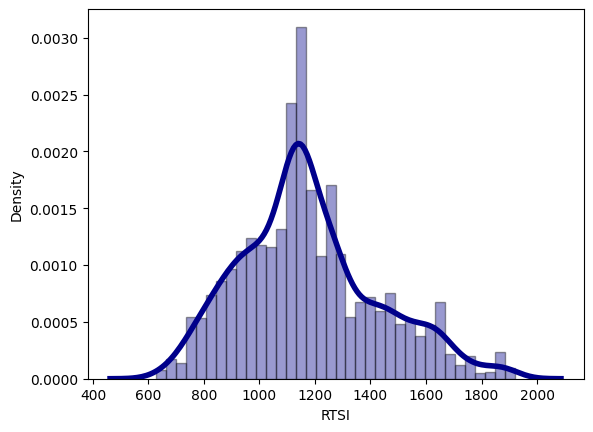

In [16]:
for i in risks.iloc[:,1:]:
    risks_info(risks[i])

## PCA

In [17]:
#дропаю дату для теста
risks = risks.drop('TRADEDATE', axis=1)

In [18]:
evs = []
for n in tqdm(range(1, risks.shape[1])):
    reduced = PCA(n_components = n, random_state=0)
    reduced.fit(risks)
    ev = np.sum(reduced.explained_variance_ratio_)
    evs.append(ev)
    print(f'Количество компонент: {n}')
    print(f'Объясненная дисперсия: {ev}')

100%|██████████| 18/18 [00:00<00:00, 74.08it/s]

Количество компонент: 1
Объясненная дисперсия: 0.866743771697692
Количество компонент: 2
Объясненная дисперсия: 0.9962907403056926
Количество компонент: 3
Объясненная дисперсия: 0.9997635404614263
Количество компонент: 4
Объясненная дисперсия: 0.9999678308420139
Количество компонент: 5
Объясненная дисперсия: 0.9999910356048227
Количество компонент: 6
Объясненная дисперсия: 0.9999963522021513
Количество компонент: 7
Объясненная дисперсия: 0.9999985321585942
Количество компонент: 8
Объясненная дисперсия: 0.9999993196287831
Количество компонент: 9
Объясненная дисперсия: 0.9999996748042506
Количество компонент: 10
Объясненная дисперсия: 0.9999998970914188
Количество компонент: 11
Объясненная дисперсия: 0.9999999796451822
Количество компонент: 12
Объясненная дисперсия: 0.9999999960027798
Количество компонент: 13
Объясненная дисперсия: 0.9999999992677266
Количество компонент: 14
Объясненная дисперсия: 0.9999999998120137
Количество компонент: 15
Объясненная дисперсия: 0.9999999999397547
Колич

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=evs, x=[i for i in range(1,risks.shape[1]+1)],
                         name='зав-ть'))

fig.update_layout(
   title_text='Доля объясненной дисперсии в зав-ти от кол-ва компонент',
   xaxis_title_text='кол-во компонент',
   yaxis_title_text='доля объясненной дисперсии'
)

#### после PCA оставим 2 компоненты

In [20]:
reduced = PCA(n_components = 2, random_state=0)
ir_pca = pd.DataFrame(reduced.fit_transform(risks),
                      columns=['ir_comp_1', 'ir_comp_2'])
ir_pca.head()

ir_comp_1   ir_comp_2
0 -1234.247492  413.932262
1 -1341.389736   67.756473
2 -1088.134791  466.794643
3 -1172.348172  418.838705
4 -1149.041996  424.262061

# Часть 3

оценка стохастической модели динамики риск факторов
Для симуляции динамики воспользуемся моделью Блэка-Шоулза.

Симуляции periods

In [21]:
ir_pca['TRADEDATE'] = df['TRADEDATE']
ir_pca

ir_comp_1   ir_comp_2  TRADEDATE
0    -1234.247492  413.932262 2015-01-06
1    -1341.389736   67.756473 2015-01-07
2    -1088.134791  466.794643 2015-01-09
3    -1172.348172  418.838705 2015-01-12
4    -1149.041996  424.262061 2015-01-13
...           ...         ...        ...
1778   443.248454  822.154804 2022-12-26
1779   436.683808  812.812852 2022-12-27
1780   493.243568  883.105351 2022-12-28
1781   561.692780  925.489341 2022-12-29
1782   606.596566  933.604031 2022-12-30

[1783 rows x 3 columns]

In [22]:
LAST_TRAIN_OBS = 1782
HORIZONS = [1, 10, 30]
rf_bs =  ir_pca[['ir_comp_1', 'ir_comp_2']]


log_diffs = np.log(rf_bs).diff().dropna()
corr_matrix = rf_bs.diff().dropna().corr()
log_corr_matrix = log_diffs.corr()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log



In [23]:
m = log_diffs.mean()
v = log_diffs.var()

In [24]:
sigma = np.sqrt(v)
r = m + 0.5 * sigma ** 2

sigma = sigma.values.reshape(-1, 1)
r = r.values.reshape(-1, 1)

In [25]:
np.random.seed(0)
t_simulations = 1000
alpha = 0.01
# current portfolio value
portval_start = 1000000

In [26]:
LAST_TRAIN_OBS

1782

In [27]:
# General share info
S_0 = rf_bs.loc[LAST_TRAIN_OBS].values.reshape(-1, 1)
L = np.linalg.cholesky(log_corr_matrix)
T = 1

In [28]:
def terminal_shareprice(S_0, r, sigma, Z, T):
    """
    Generates the terminal share price given some random normal values, z
    """
    # It returns an array of terminal stock prices.
    return S_0*np.exp((r-sigma**2/2)*T+sigma*np.sqrt(T)*Z)

In [29]:
Z = np.matmul(L, norm.rvs(size= [S_0.shape[0], t_simulations]))

In [30]:
portfolio_assets_sim = terminal_shareprice(S_0, r, sigma, Z, T)

<Axes: ylabel='Count'>

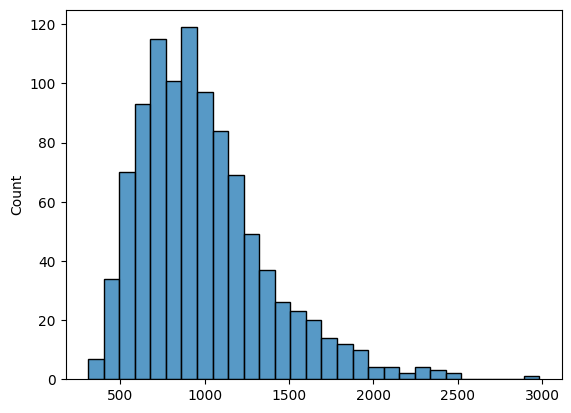

In [31]:
sns.histplot(portfolio_assets_sim[1,:])

In [32]:
def share_path(S_0, r, sigma, Z, dT):
    """
    Generates the terminal share price given some random normal values, Z
    """
    return S_0*np.exp(np.cumsum((r - sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))

# generate synthetic share data

Z_histdata = norm.rvs(size = [S_0.shape[0], 30])
corr_Z = np.matmul(L, Z_histdata)
price_path = share_path(S_0, r, sigma, corr_Z, 1)

In [33]:
sims = price_path[:,:,None]

for i in range(t_simulations - 1):
  Z_histdata = norm.rvs(size = [S_0.shape[0], 30])
  corr_Z = np.matmul(L, Z_histdata)
  price_path = share_path(S_0, r, sigma, corr_Z, 1)
  price_path = price_path[:,:,None]
  sims = np.concatenate((sims, price_path),  axis=-1)

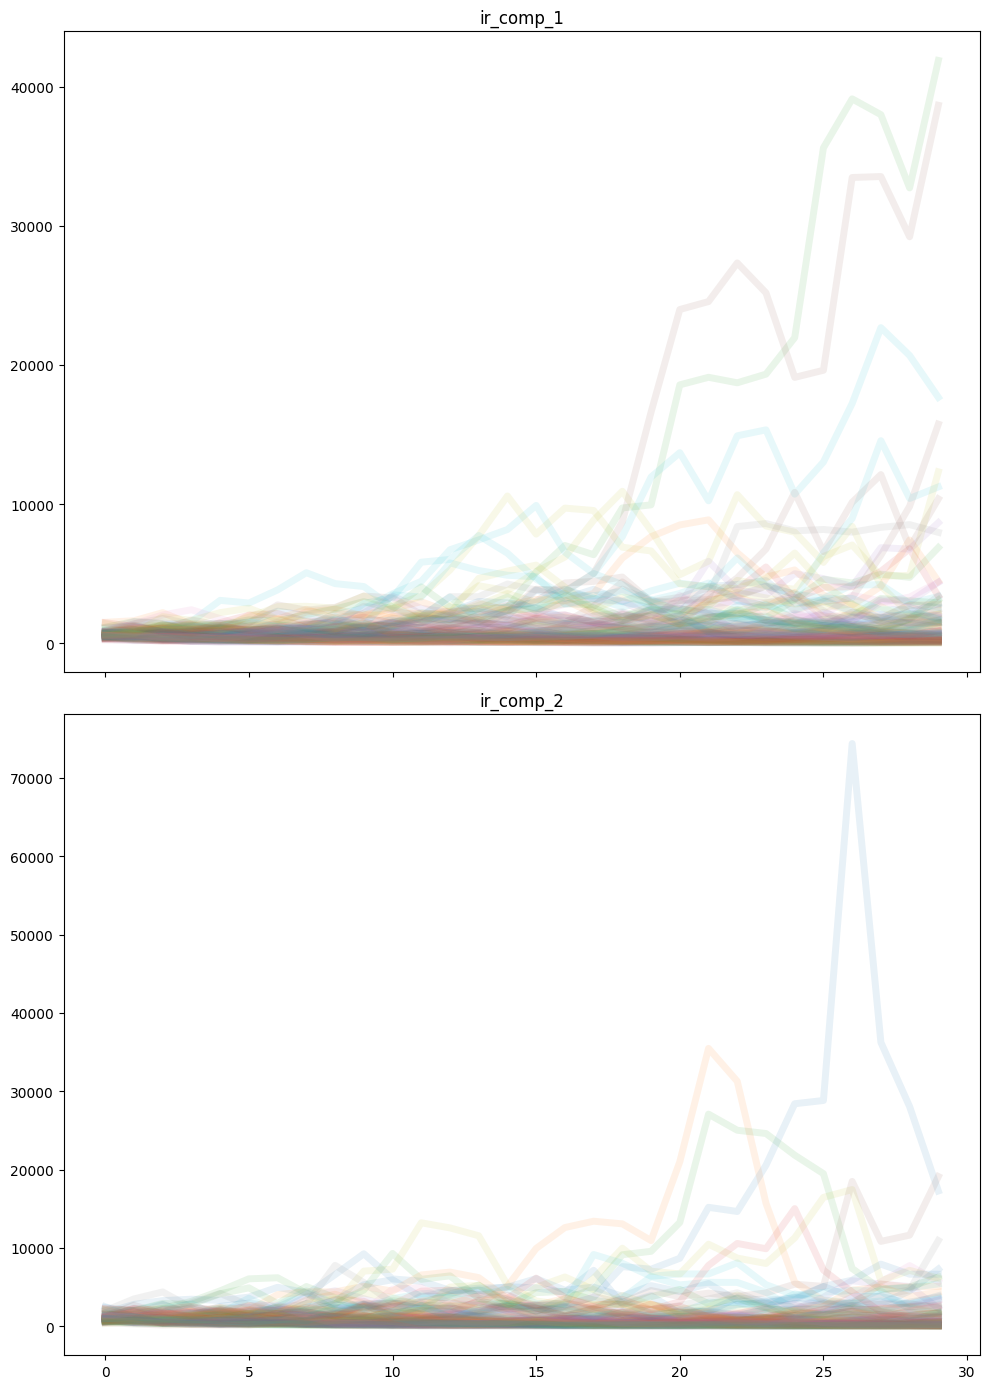

In [34]:
fig, ax = plt.subplots(S_0.shape[0], figsize=(10, 14), sharex=True)

for i, equisim in enumerate(sims):
  ax_ = ax.flatten()[i]
  ax_.plot(equisim[:,:100], alpha=.1, linewidth = 5)
  ax_.set(ylabel='', xlabel='', title=rf_bs.columns[i])

plt.tight_layout()
plt.show()

Симуляция нефти-золота

In [35]:
LAST_TRAIN_OBS = 1782
HORIZONS = [1, 10, 30]
rf_bs =  df[['ICE.BRN', 'Gold']]
rf_bs['EUR'] = df['EUR']

log_diffs = np.log(rf_bs).diff().dropna()
corr_matrix = rf_bs.diff().dropna().corr()
log_corr_matrix = log_diffs.corr()

<ipython-input-35-9fe7deaff275>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
m = log_diffs.mean()
v = log_diffs.var()
sigma = np.sqrt(v)
r = m + 0.5 * sigma ** 2
sigma = sigma.values.reshape(-1, 1)
r = r.values.reshape(-1, 1)
np.random.seed(0)
t_simulations = 1000
alpha = 0.01
portval_start = 1000000
S_0 = rf_bs.loc[LAST_TRAIN_OBS].values.reshape(-1, 1)
L = np.linalg.cholesky(log_corr_matrix)
T = 1
Z = np.matmul(L, norm.rvs(size= [S_0.shape[0], t_simulations]))
portfolio_assets_sim = terminal_shareprice(S_0, r, sigma, Z, T)

<Axes: ylabel='Count'>

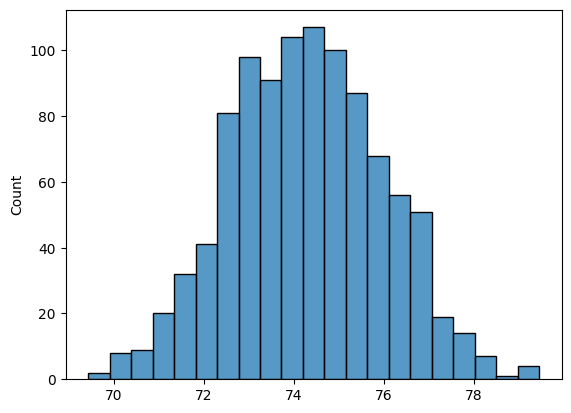

In [37]:
sns.histplot(portfolio_assets_sim[2,:])

In [38]:
Z_histdata = norm.rvs(size = [S_0.shape[0], 30])
corr_Z = np.matmul(L, Z_histdata)
price_path = share_path(S_0, r, sigma, corr_Z, 1)

In [39]:
sims = price_path[:,:,None]

for i in range(t_simulations - 1):
  Z_histdata = norm.rvs(size = [S_0.shape[0], 30])
  corr_Z = np.matmul(L, Z_histdata)
  price_path = share_path(S_0, r, sigma, corr_Z, 1)
  price_path = price_path[:,:,None]
  sims = np.concatenate((sims, price_path),  axis=-1)

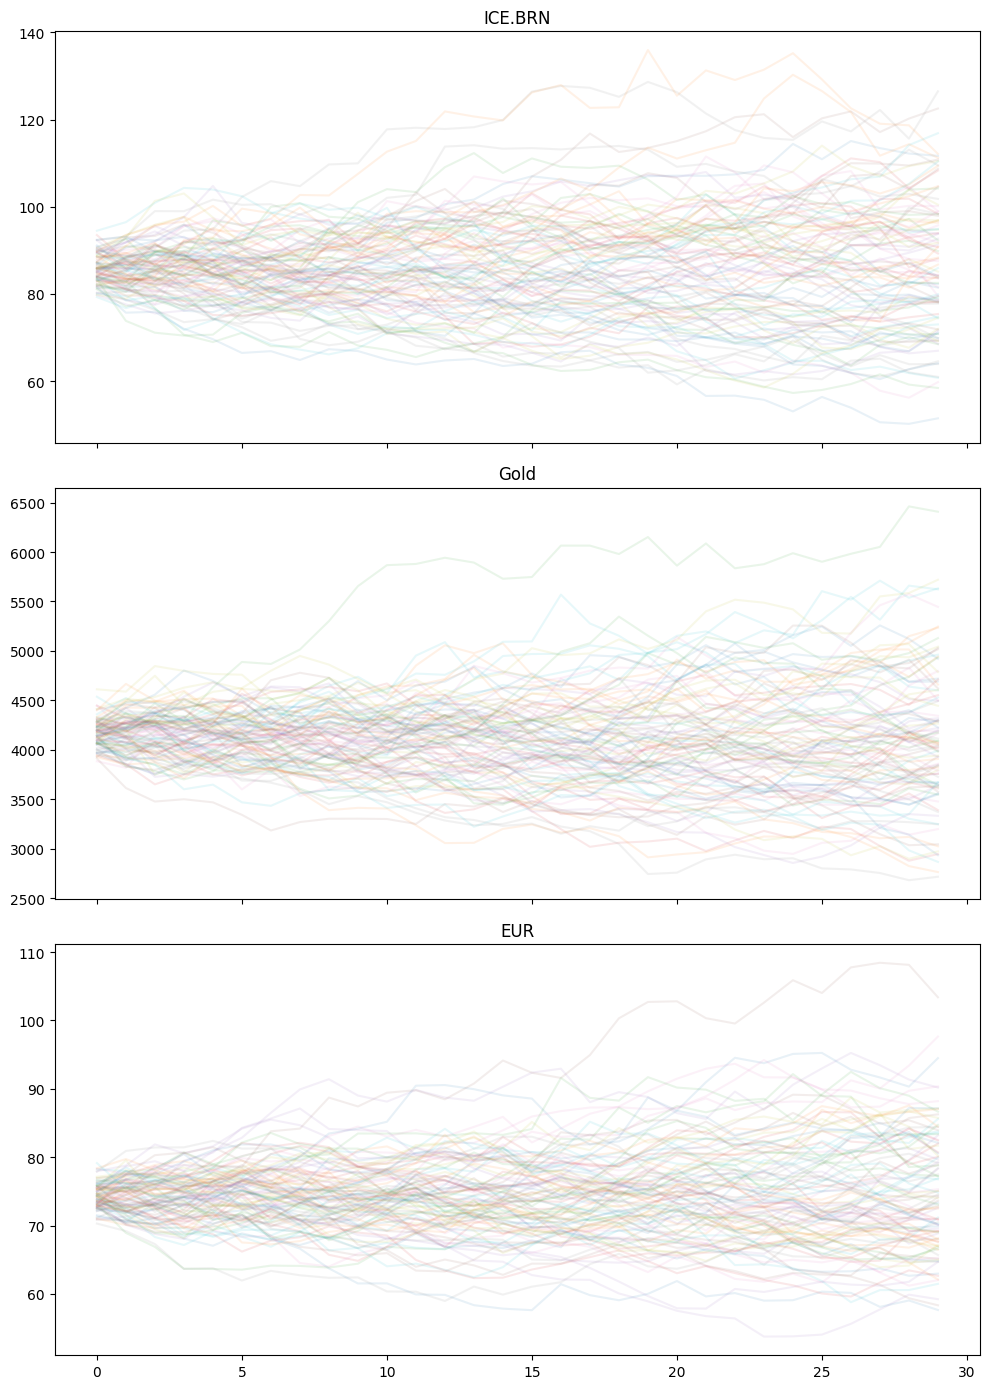

In [40]:
fig, ax = plt.subplots(S_0.shape[0], figsize=(10, 14), sharex=True)

for i, equisim in enumerate(sims):
  ax_ = ax.flatten()[i]
  ax_.plot(equisim[:,:100], alpha=.1)
  ax_.set(ylabel='', xlabel='', title=rf_bs.columns[i])

plt.tight_layout()
plt.show()

Распределение риск-факторов

In [41]:
def logarithm(df):
    df_log = df.copy()
    for col in df_log.columns:
            df_log[col] = np.log(1 + df_log[col]).diff()
    return df_log.dropna()

In [42]:
idx_df = risks[['IMOEX', 'RTSI']]
idx_df_log = logarithm(idx_df)

In [43]:
gold_oil = risks[['ICE.BRN', 'Gold']]
gold_oil_log = logarithm(gold_oil)

In [44]:
pca = PCA(n_components = 2, random_state=42)
reduced_indexes = pca.fit_transform(idx_df_log)
print(np.sum(pca.explained_variance_ratio_))
reduced_curr_oil = pca.fit_transform(gold_oil_log)
print(np.sum(pca.explained_variance_ratio_))

1.0
1.0


In [45]:
reduced_data = pd.DataFrame(np.hstack([reduced_indexes, reduced_curr_oil]),
                            columns=['reduced_indexes_1', 'reduced_indexes_2',
                                     'reduced_gold_oil_1', 'reduced_gold_oil_2'
                                     ],
                            index=idx_df_log.index)

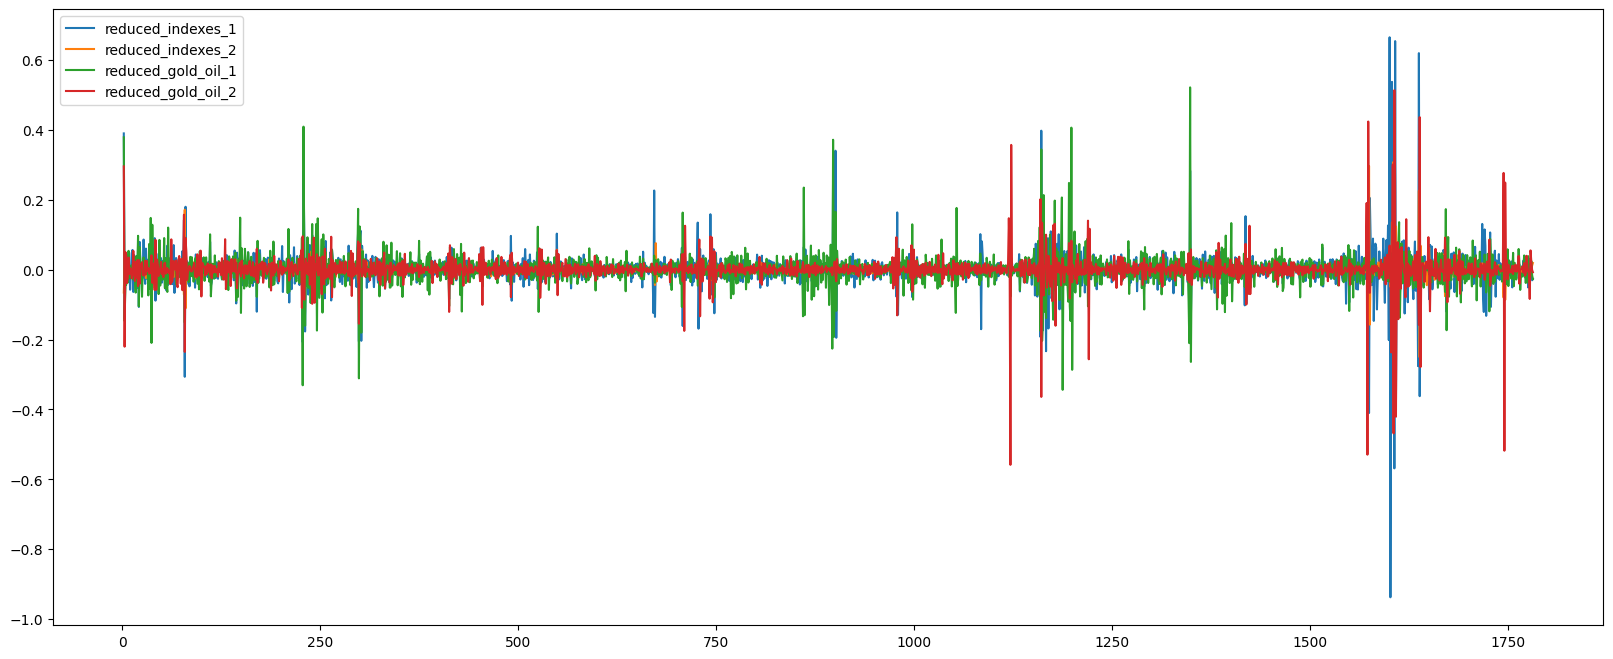

In [46]:
reduced_data.diff().dropna().plot(figsize=(20, 8))
plt.show()

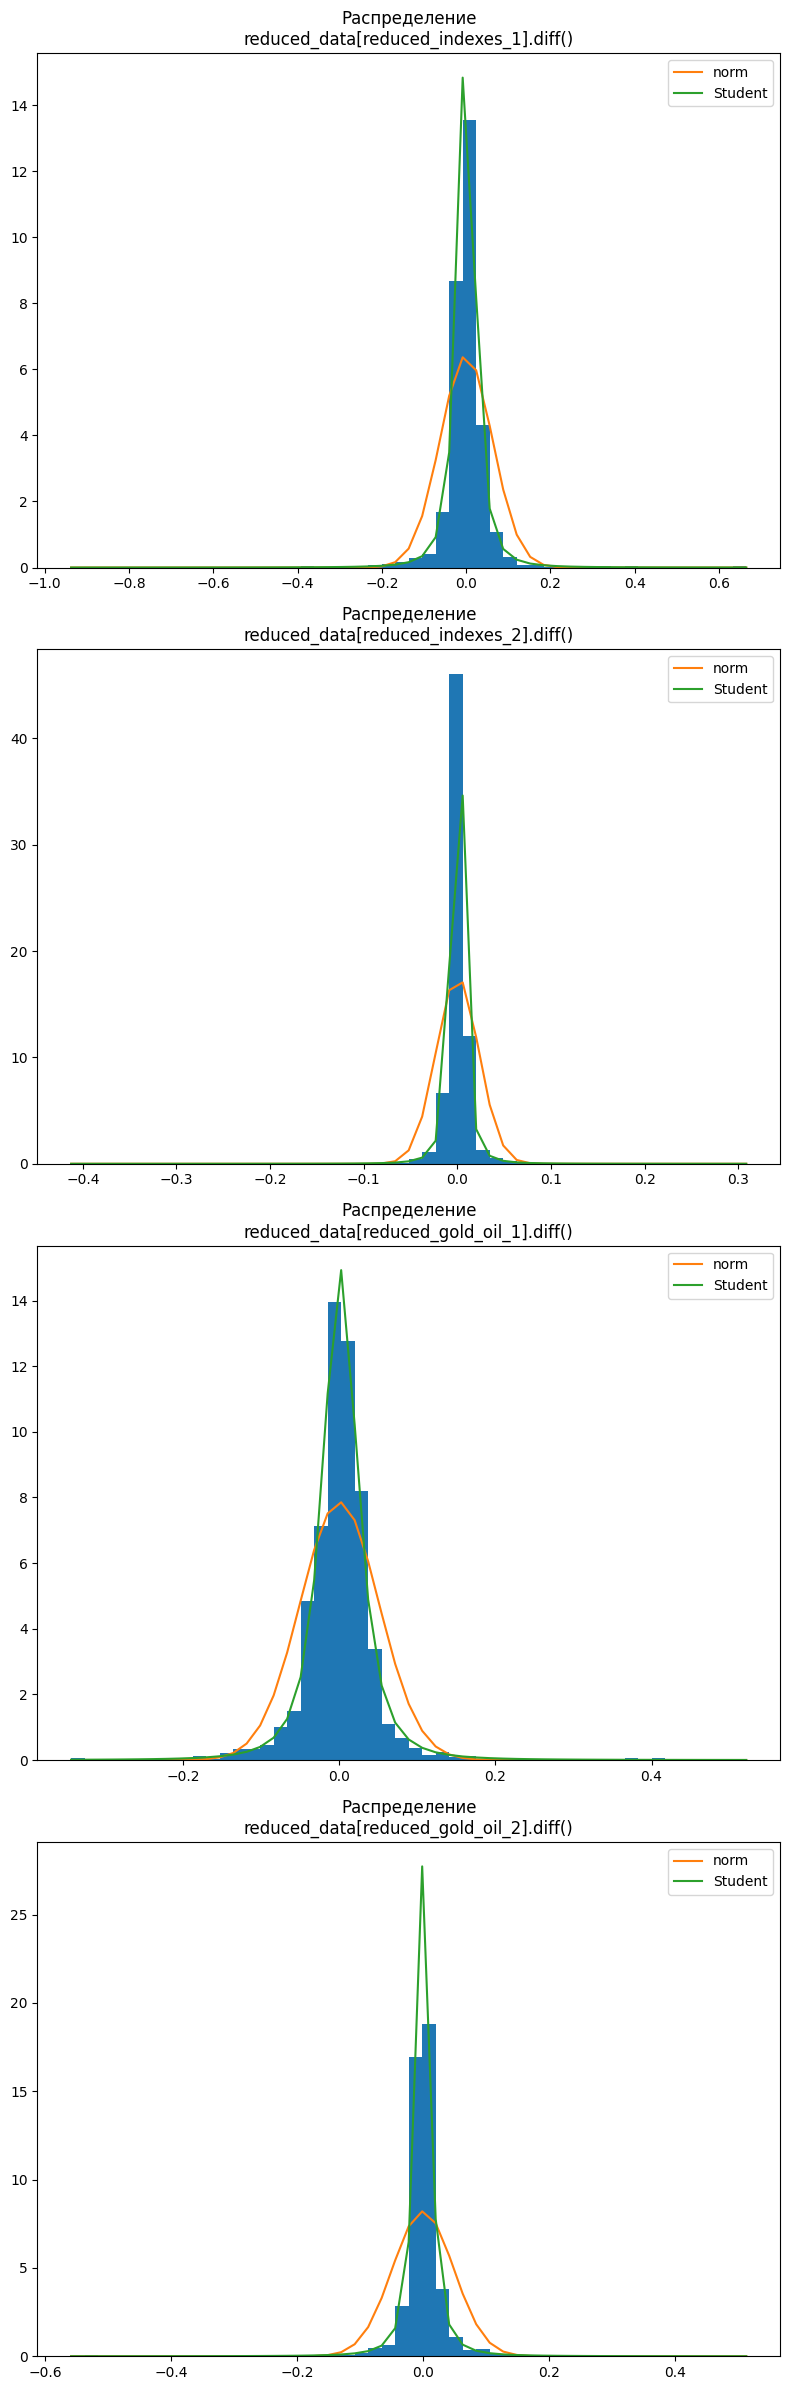

In [47]:
fig, ax = plt.subplots(len(reduced_data.columns), 1, figsize=(8, 24))
for i, col in enumerate(reduced_data.columns):
    r = reduced_data[col].diff().dropna()
    params_norm = stats.norm.fit(r)
    params_t = stats.t.fit(r)
    vals, grid, _ = ax[i].hist(r, 50, density=True)
    ax[i].plot(grid, stats.norm(*params_norm).pdf(grid), label='norm')
    ax[i].plot(grid, stats.t(*params_t).pdf(grid),label='Student');
    ax[i].legend()
    ax[i].set_title(f'Распределение\nreduced_data[{col}].diff()')
    plt.tight_layout()

# Часть 4

In [48]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [49]:
reduced_data

reduced_indexes_1  reduced_indexes_2  reduced_gold_oil_1  \
1             -0.220521           0.037242           -0.177903   
2              0.169177          -0.028288            0.200525   
3              0.028462          -0.018444            0.053296   
4              0.012986          -0.025125            0.009262   
5             -0.013504          -0.007073           -0.034253   
...                 ...                ...                 ...   
1778          -0.015434           0.002578           -0.010169   
1779           0.011109          -0.014442           -0.006844   
1780           0.026187          -0.012160            0.017784   
1781          -0.004378          -0.000781            0.001914   
1782          -0.030427           0.018081           -0.025377   

      reduced_gold_oil_2  
1              -0.117981  
2               0.177276  
3              -0.043254  
4               0.006944  
5               0.048627  
...                  ...  
1778           -0.058187  
1779           -0.003225  
1780            0.020135  
1781            0.019306  
1782            0.011782  

[1782 rows x 4 columns]

In [50]:
reduced_data['TRADEDATE'] = df['TRADEDATE']

In [51]:
reduced_data = reduced_data.set_index('TRADEDATE')

In [52]:
reduced_data

reduced_indexes_1  reduced_indexes_2  reduced_gold_oil_1  \
TRADEDATE                                                              
2015-01-07          -0.220521           0.037242           -0.177903   
2015-01-09           0.169177          -0.028288            0.200525   
2015-01-12           0.028462          -0.018444            0.053296   
2015-01-13           0.012986          -0.025125            0.009262   
2015-01-14          -0.013504          -0.007073           -0.034253   
...                       ...                ...                 ...   
2022-12-26          -0.015434           0.002578           -0.010169   
2022-12-27           0.011109          -0.014442           -0.006844   
2022-12-28           0.026187          -0.012160            0.017784   
2022-12-29          -0.004378          -0.000781            0.001914   
2022-12-30          -0.030427           0.018081           -0.025377   

            reduced_gold_oil_2  
TRADEDATE                       
2015-01-07           -0.117981  
2015-01-09            0.177276  
2015-01-12           -0.043254  
2015-01-13            0.006944  
2015-01-14            0.048627  
...                        ...  
2022-12-26           -0.058187  
2022-12-27           -0.003225  
2022-12-28            0.020135  
2022-12-29            0.019306  
2022-12-30            0.011782  

[1782 rows x 4 columns]

In [53]:
bonds = df[df_data_info['bonds']]
bonds['TRADEDATE'] = df['TRADEDATE']
bonds = bonds.set_index('TRADEDATE')
bonds_y = bonds
bonds_y = bonds_y.pct_change().dropna()
bonds_y.index = pd.to_datetime(bonds_y.index)
idx = pd.date_range("2015-01-05", "2022-12-30")
bonds_y.reindex(idx).interpolate(inplace=True)
risks = reduced_data
risks = sm.add_constant(risks)
reses_bonds = []
preds_bonds = []

<ipython-input-53-3b5641064dd4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



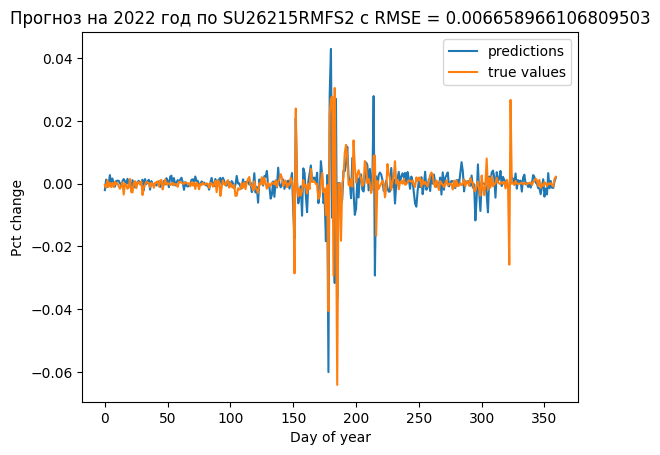

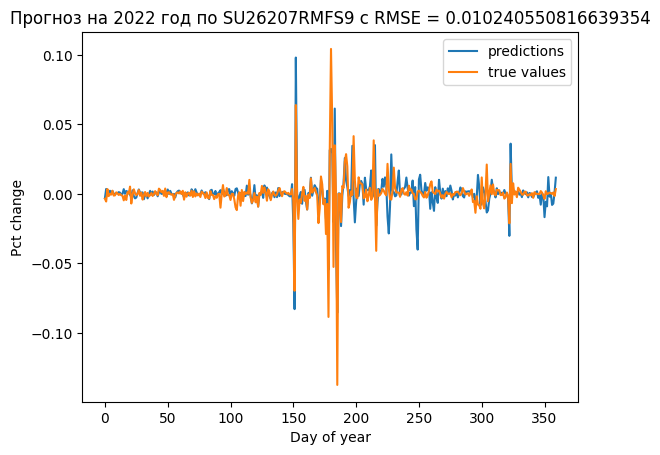

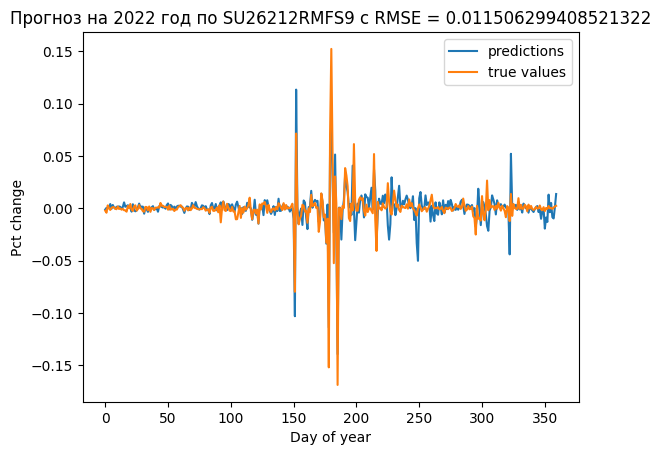

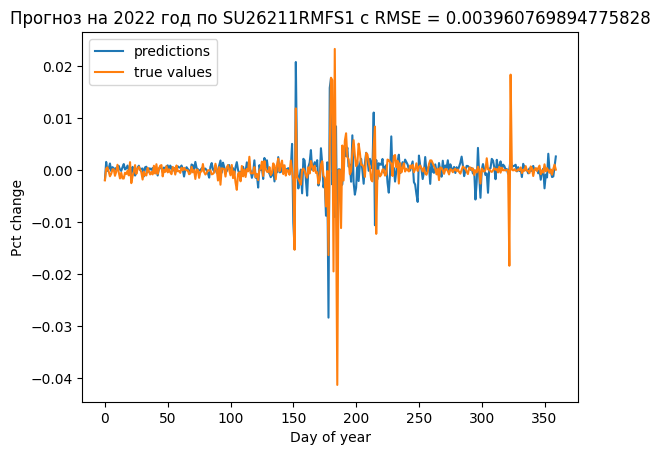

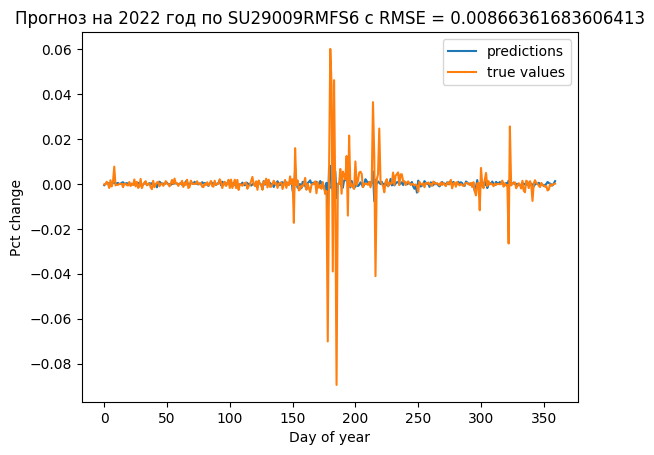

In [54]:
for i in df_data_info['bonds']:
    # Для саммари
    model = sm.OLS(bonds_y[i].values, risks)
    res = model.fit()
    reses_bonds.append(res.summary())

    # Для валидации
    model_val = sm.OLS(bonds_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()

    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_bonds.append(ypred)

    try:
        error_i = mean_squared_error(bonds_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_bonds[-1], label = 'predictions')
        plt.plot(bonds_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2022 год по {} с RMSE = {}'.format(i, error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

In [55]:
reses_bonds[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     28.60
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           4.59e-23
Time:                        23:00:25   Log-Likelihood:                 5441.8
No. Observations:                1782   AIC:                        -1.087e+04
Df Residuals:                    1777   BIC:                        -1.085e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0002      0.000      0.716      0.474      -0.000       0.001
reduced_indexes_1     -0.0612      0.007     -8.509      0.000      -0.075      -0.047
reduced_indexes_2      0.1105      0.022      4.990      0.000       0.067       0.154
reduced_gold_oil_1     0.0390      0.009      4.422      0.000       0.022       0.056
reduced_gold_oil_2    -0.0181      0.010     -1.851      0.064      -0.037       0.001
==============================================================================
Omnibus:                      752.664   Durbin-Watson:                   2.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           973677.019
Skew:                           0.179   Prob(JB):                         0.00
Kurtosis:                     117.514   Cond. No.                         84.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
stocks = df[df_data_info['stocks']]
stocks['TRADEDATE'] = df['TRADEDATE']
stocks = stocks.set_index('TRADEDATE')
stocks_y = stocks
stocks_y = stocks_y.pct_change().dropna()
stocks_y.index = pd.to_datetime(stocks_y.index)
idx = pd.date_range("2015-01-05", "2022-12-30")
stocks_y.reindex(idx).interpolate(inplace=True)
risks = reduced_data
risks = sm.add_constant(risks)
reses_bonds = []
preds_bonds = []

<ipython-input-56-67ce3acc72f3>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
reses_stocks, preds_stocks = [], []

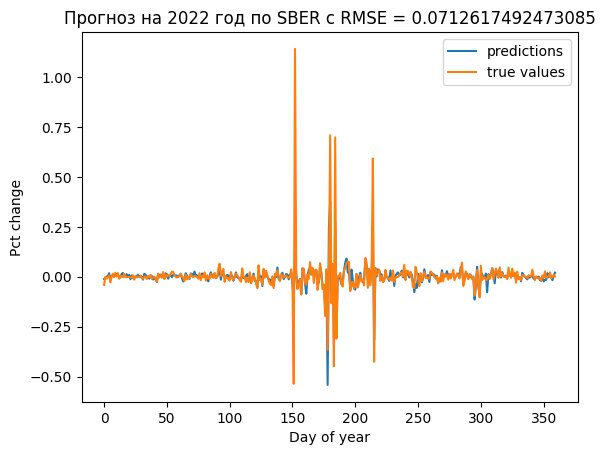

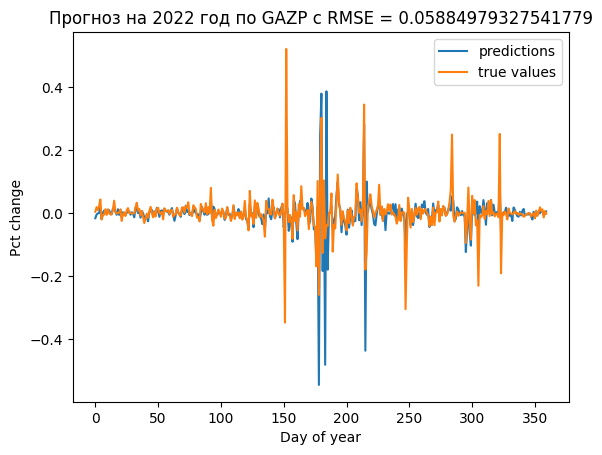

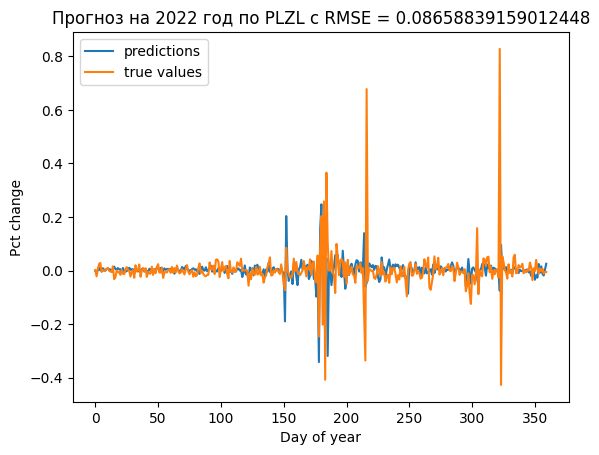

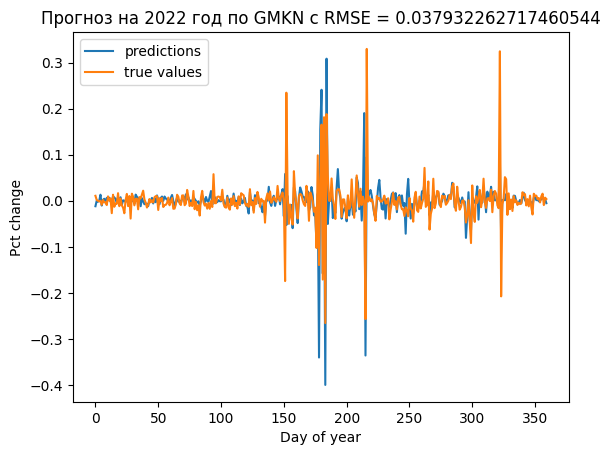

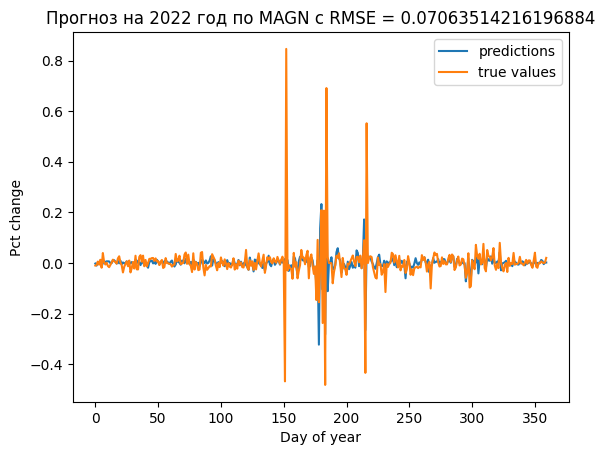

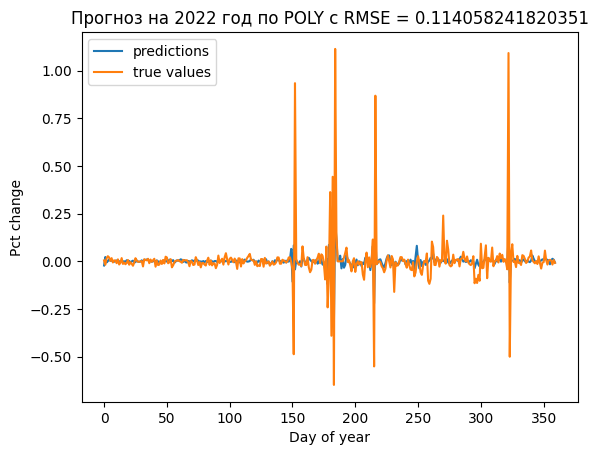

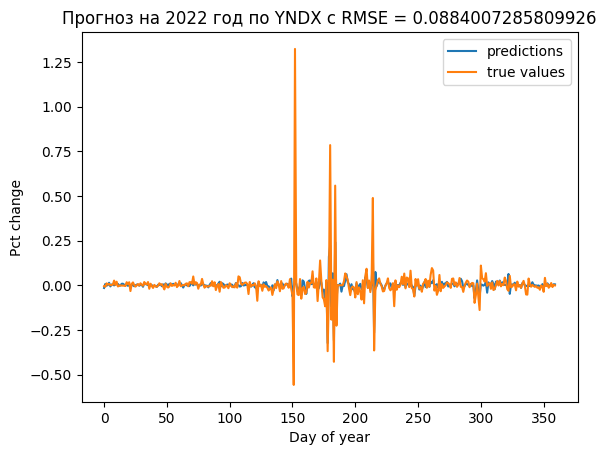

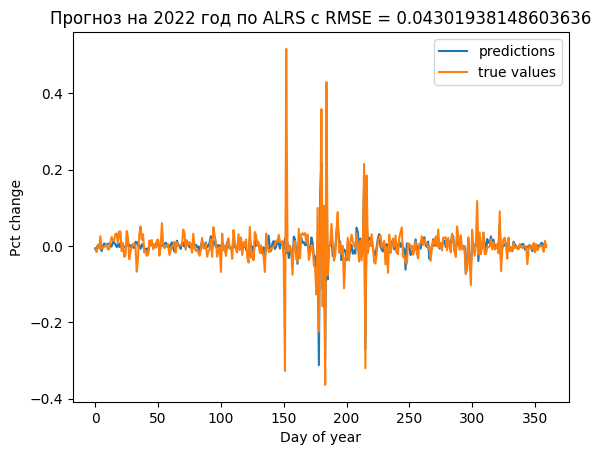

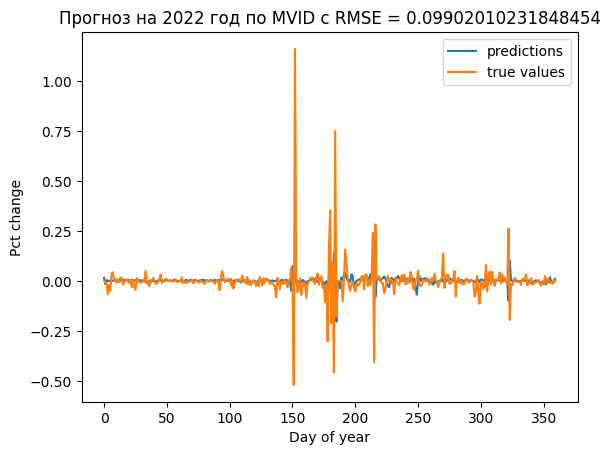

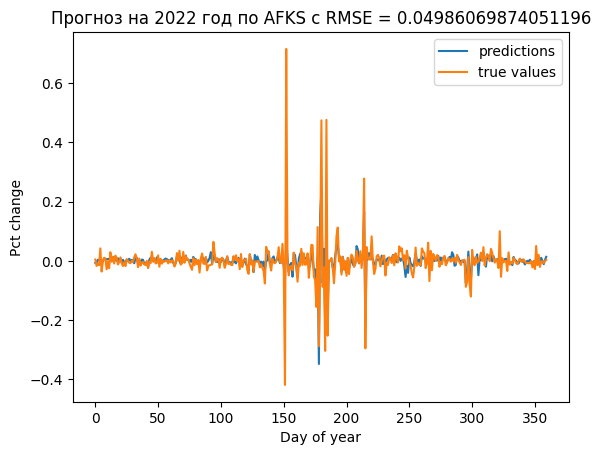

In [58]:
for i in df_data_info['stocks']:
    # Для саммари
    model = sm.OLS(stocks_y[i].values, risks)
    res = model.fit()
    reses_stocks.append(res.summary())

    # Для валидации
    model_val = sm.OLS(stocks_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()

    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_stocks.append(ypred)

    try:
        error_i = mean_squared_error(stocks_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_stocks[-1], label = 'predictions')
        plt.plot(stocks_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2022 год по {} с RMSE = {}'.format(i, error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

In [ ]:
reses_stocks

In [60]:
currencys = df[df_data_info['currency']]
currencys['TRADEDATE'] = df['TRADEDATE']
currencys = currencys.set_index('TRADEDATE')
currs_y = currencys
currs_y = currs_y.pct_change().dropna()
currs_y.index = pd.to_datetime(currs_y.index)
idx = pd.date_range("2015-01-05", "2022-12-30")
currs_y.reindex(idx).interpolate(inplace=True)
risks = reduced_data
risks = sm.add_constant(risks)

<ipython-input-60-d028cdef446c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
currs_y

EUR       USD
TRADEDATE                     
2015-01-07 -0.172243  0.038269
2015-01-09  0.165226 -0.046073
2015-01-12  0.033688  0.019585
2015-01-13  0.030863  0.028569
2015-01-14 -0.009352  0.031653
...              ...       ...
2022-12-26 -0.028402  0.029319
2022-12-27  0.019714 -0.026846
2022-12-28  0.018667  0.023928
2022-12-29 -0.005236  0.039305
2022-12-30 -0.022368  0.017190

[1782 rows x 2 columns]

In [62]:
reses_currs, preds_curs = [], []

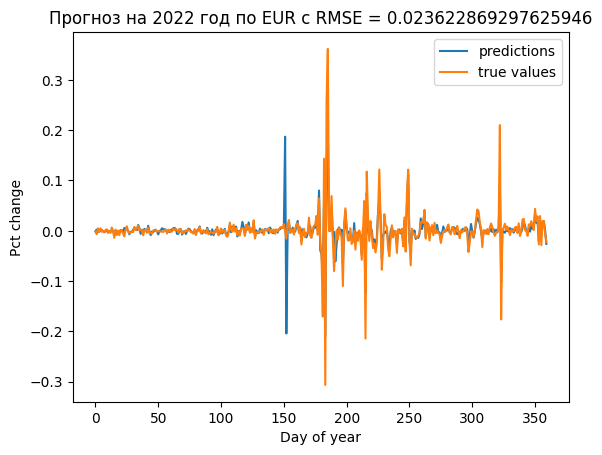

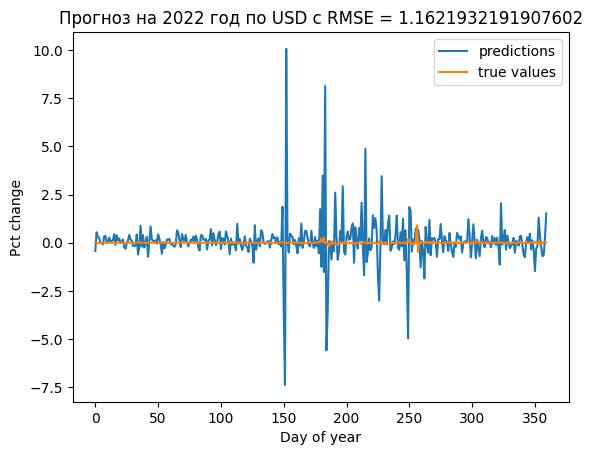

In [63]:
for i  in df_data_info['currency']:
    model = sm.OLS(currs_y[i].values, risks)
    res = model.fit()
    reses_currs.append(res.summary())


    # Для валидации
    model_val = sm.OLS(currs_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()

    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_curs.append(ypred)

    try:
        error_i = mean_squared_error(currs_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_curs[-1], label = 'predictions')
        plt.plot(currs_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2022 год по {} с RMSE = {}'.format(i, error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

In [64]:
reses_currs

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.713
 Model:                            OLS   Adj. R-squared:                  0.713
 Method:                 Least Squares   F-statistic:                     1104.
 Date:                Fri, 30 Jun 2023   Prob (F-statistic):               0.00
 Time:                        23:00:36   Log-Likelihood:                 5281.2
 No. Observations:                1782   AIC:                        -1.055e+04
 Df Residuals:                    1777   BIC:                        -1.053e+04
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------

# 5

In [ ]:
gpu_devices = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpu_devices[0], enable=True)
tf.keras.backend.set_floatx(value="float64")
tf.config.run_functions_eagerly(run_eagerly=True)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline
from PIL import Image
import plotnine

# print("TensorFlow version:", tf.__version__)
# print("GPU:", gpu_devices)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkDiscriminator(tf.keras.Model):
    def __init__(self, num_hidden):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.feature_extractor = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
            ]
        )
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.discriminator = tf.keras.layers.Dense(
            units=1,
            activation="sigmoid",
        )

    def call(self, x, z):
        features = self.concat([x, z])
        features = self.feature_extractor(features)
        features = self.dropout(features)

        return self.discriminator(features)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkGenerator(tf.keras.Model):
    def __init__(self, num_hidden, num_inputs):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.generator = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_inputs,
                    activation="linear",
                ),
            ]
        )

    def call(self, z):
        return self.generator(z)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkEncoder(tf.keras.Model):
    def __init__(self, num_hidden, num_encoding):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.Dense(
                    units=self.num_encoding,
                    activation="tanh",
                ),
            ]
        )

    def call(self, x):
        return self.encoder(x)

In [ ]:
@tf.function
def train_step(x, real, z, fake):
    with tf.GradientTape() as dis_tape, tf.GradientTape(
        persistent=True
    ) as enc_gen_tape:
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        disc_loss_real = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        disc_loss_fake = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        enc_loss = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        gen_loss = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
    gradients_disc = dis_tape.gradient(
        target=disc_loss,
        sources=discriminator.trainable_variables,
    )
    optimizer_disc.apply_gradients(
        grads_and_vars=zip(
            gradients_disc,
            discriminator.trainable_variables,
        )
    )
    disc_loss_metric(disc_loss)
    gradients_enc = enc_gen_tape.gradient(
        target=enc_loss, sources=encoder.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_enc,
            encoder.trainable_variables,
        )
    )
    enc_loss_metric(enc_loss)
    gradients_gen = enc_gen_tape.gradient(
        target=gen_loss, sources=generator.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_gen,
            generator.trainable_variables,
        )
    )
    gen_loss_metric(gen_loss)

In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 100
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min(), high=ret_data.max(), size=(num_encoding))
                            ]
                        )
                    )[0]
                )
            )
            for i in range(num_sim)
        ]

    return np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))

In [77]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 10
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min(), high=ret_data.max(), size=(num_encoding))
                            ]
                        )
                    )[0]
                )
            )
            for i in range(num_sim)
        ]

    return np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
n_samples = 100
window = 11

common = []

for train_end_ in train_ends:
  train_end = train_end_.strftime('%Y-%m-%d')
  generated_rf = generate_riskfactors(riskfactor_df, 2000, window, train_end, n_samples)
  generated_eq = train_and_predict(riskfactor_df, portfolio_df, generated_rf)
  pv = calc_pfvalue_ondate(final_portfolio_real, train_end)
  sim_equities = generated_eq.copy()
  sim_currency = generated_rf[3:,:,:].copy()
  portfolio_prices = np.vstack([sim_equities, sim_currency])

  weights = [1] * 10 + [10] * 5 + [100] * 2
  weights = (np.array(weights) / sum(weights)).reshape(-1, 1)


  pfd_sims = []
  for simulation_unit in range(portfolio_prices.shape[1]):
    one_simulation = portfolio_prices[:, simulation_unit, :]
    start_quantities = pv * weights.flatten() / one_simulation[:,0]

    portfolio_dynamics = []

    for time_unit in range(one_simulation.shape[-1]):
      portfolio_value = start_quantities * one_simulation[:, time_unit]

      start_quantities = portfolio_value.sum() * weights.flatten() / one_simulation[:, time_unit]
      portfolio_dynamics.append(portfolio_value)

    pfd_sims.append(portfolio_dynamics)

  pfd_sims = np.array(pfd_sims)
  pfd_sims = pfd_sims.transpose(2, 0, 1)
  portfolio_value_simulations = pfd_sims.sum(axis=0)
  log_returns = np.diff(np.log(portfolio_value_simulations), axis=1)

  var_99 = bigan_var(log_returns.dot(weights), 0.99, axis=0)
  train_end_extend = (train_end_.date() + pd.Timedelta(window-1, unit='d')).strftime('%Y-%m-%d')
  real = calc_pfvalue_ondate(final_portfolio_real, train_end_extend, False)
  real_logret = np.diff(np.log(real))[-(window-1):]

  collector.append((var_99, real_logret))

In [ ]:
dates = []
vars = []
reals = []

for i, te in enumerate(train_ends):
  cl = common[i]
  daterange = pd.date_range(start=te, periods=cl[0].shape[0], freq='1D')
  dates.append(list(daterange))

  vars.append(list(cl[0]))
  reals.append(list(cl[1]))

dates = np.array(sum(dates, []))
vars = np.array(sum(vars, []))
reals = np.array(sum(reals, []))

In [ ]:
fdf = pd.DataFrame({ 'Real': reals, 'VaR': -vars}, index=dates)

In [ ]:
def tests(df):
    var = 'VaR'
    print('POF test p-value',"%.2f" % pof_test(df[var], df['Real']))
    print('IF test p-value',"%.2f" % if_test(df[var], df['Real']))

In [ ]:
fdf_cource = fdf.copy()

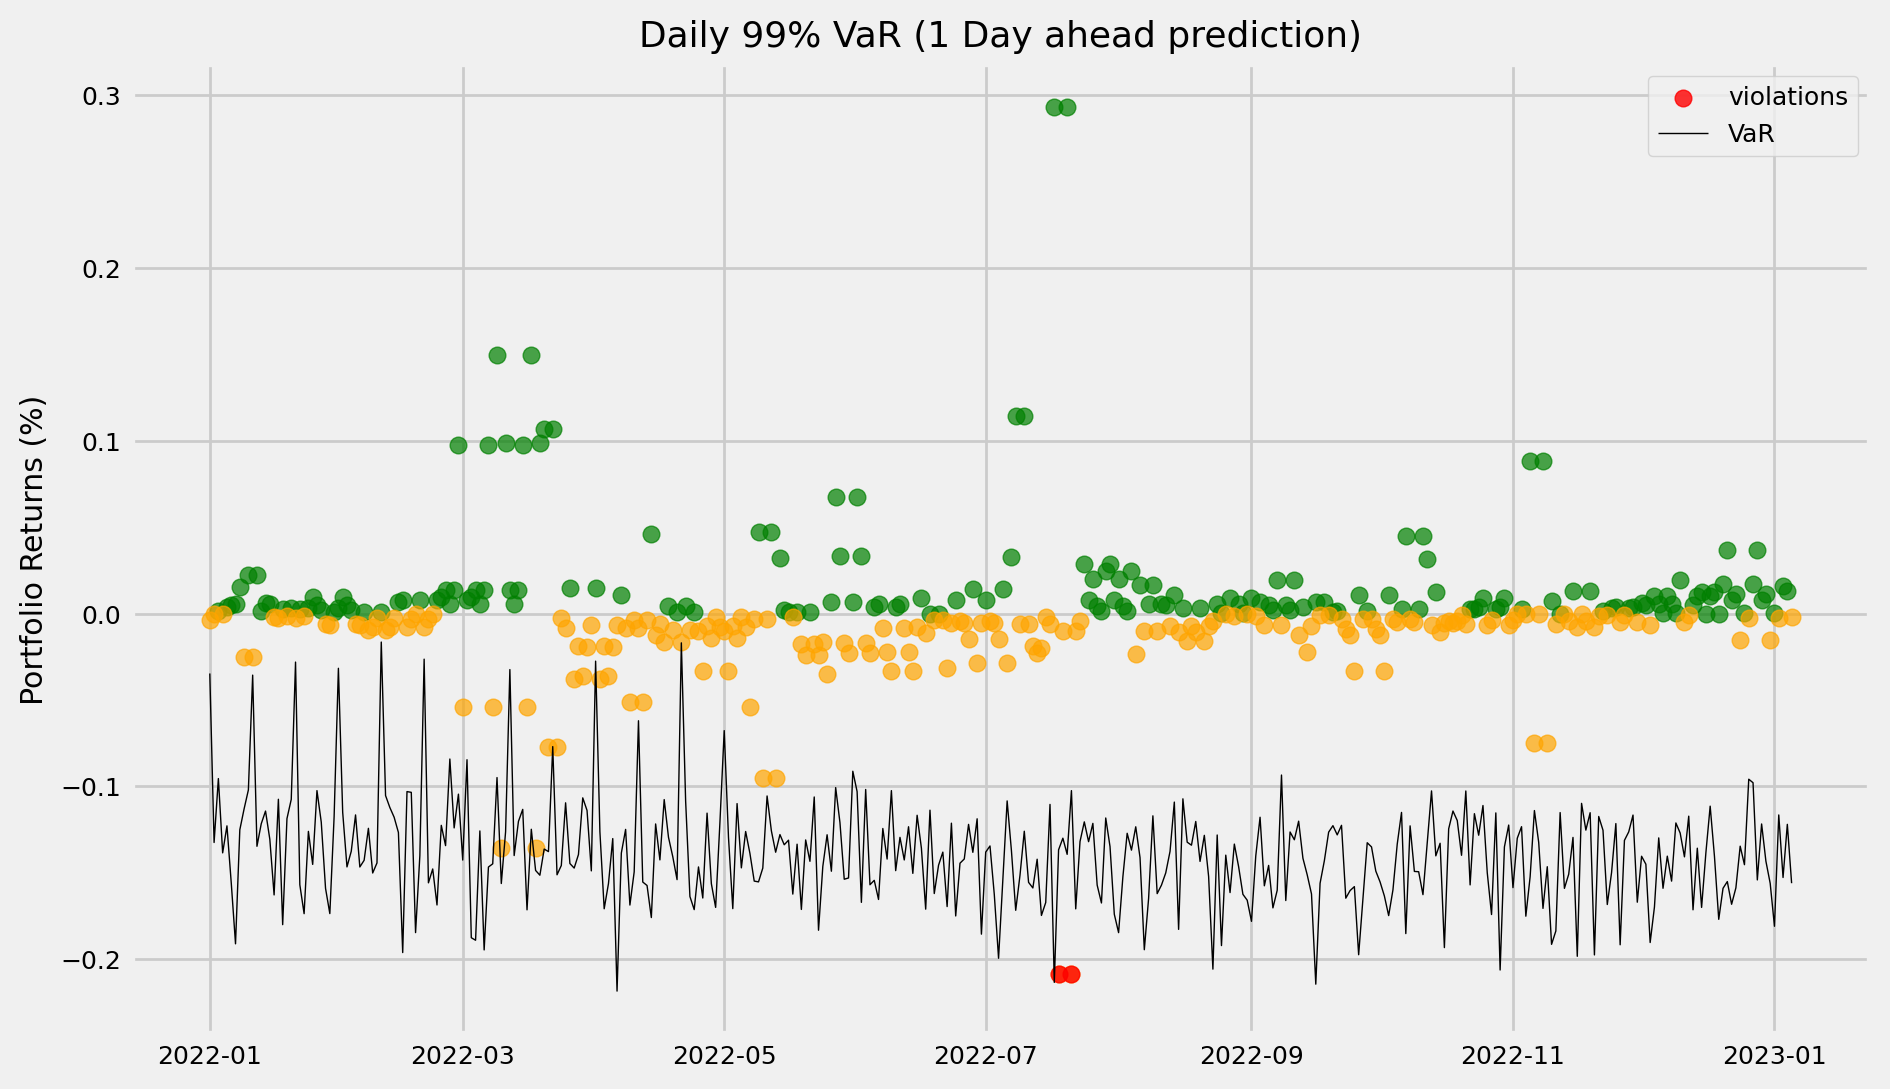

POF test p-value 0.23
IF test p-value 0.88
Число пробоев: 2


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
portf= fdf['Real']
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

fdf['Violation'] = (fdf['Real'] < fdf['VaR'])
breakdowns = fdf[fdf['Violation'] == 1]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.index, breakdowns.Real, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(fdf.index, fdf['VaR'], label = 'VaR', c = 'black')
plt.legend()
plt.title('Daily 99% VaR (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show();

tests(fdf)
print('Число пробоев: {}'.format(fdf['Violation'].sum()))

In [ ]:
fdf['VaR'] = fdf['VaR']*np.sqrt(10)

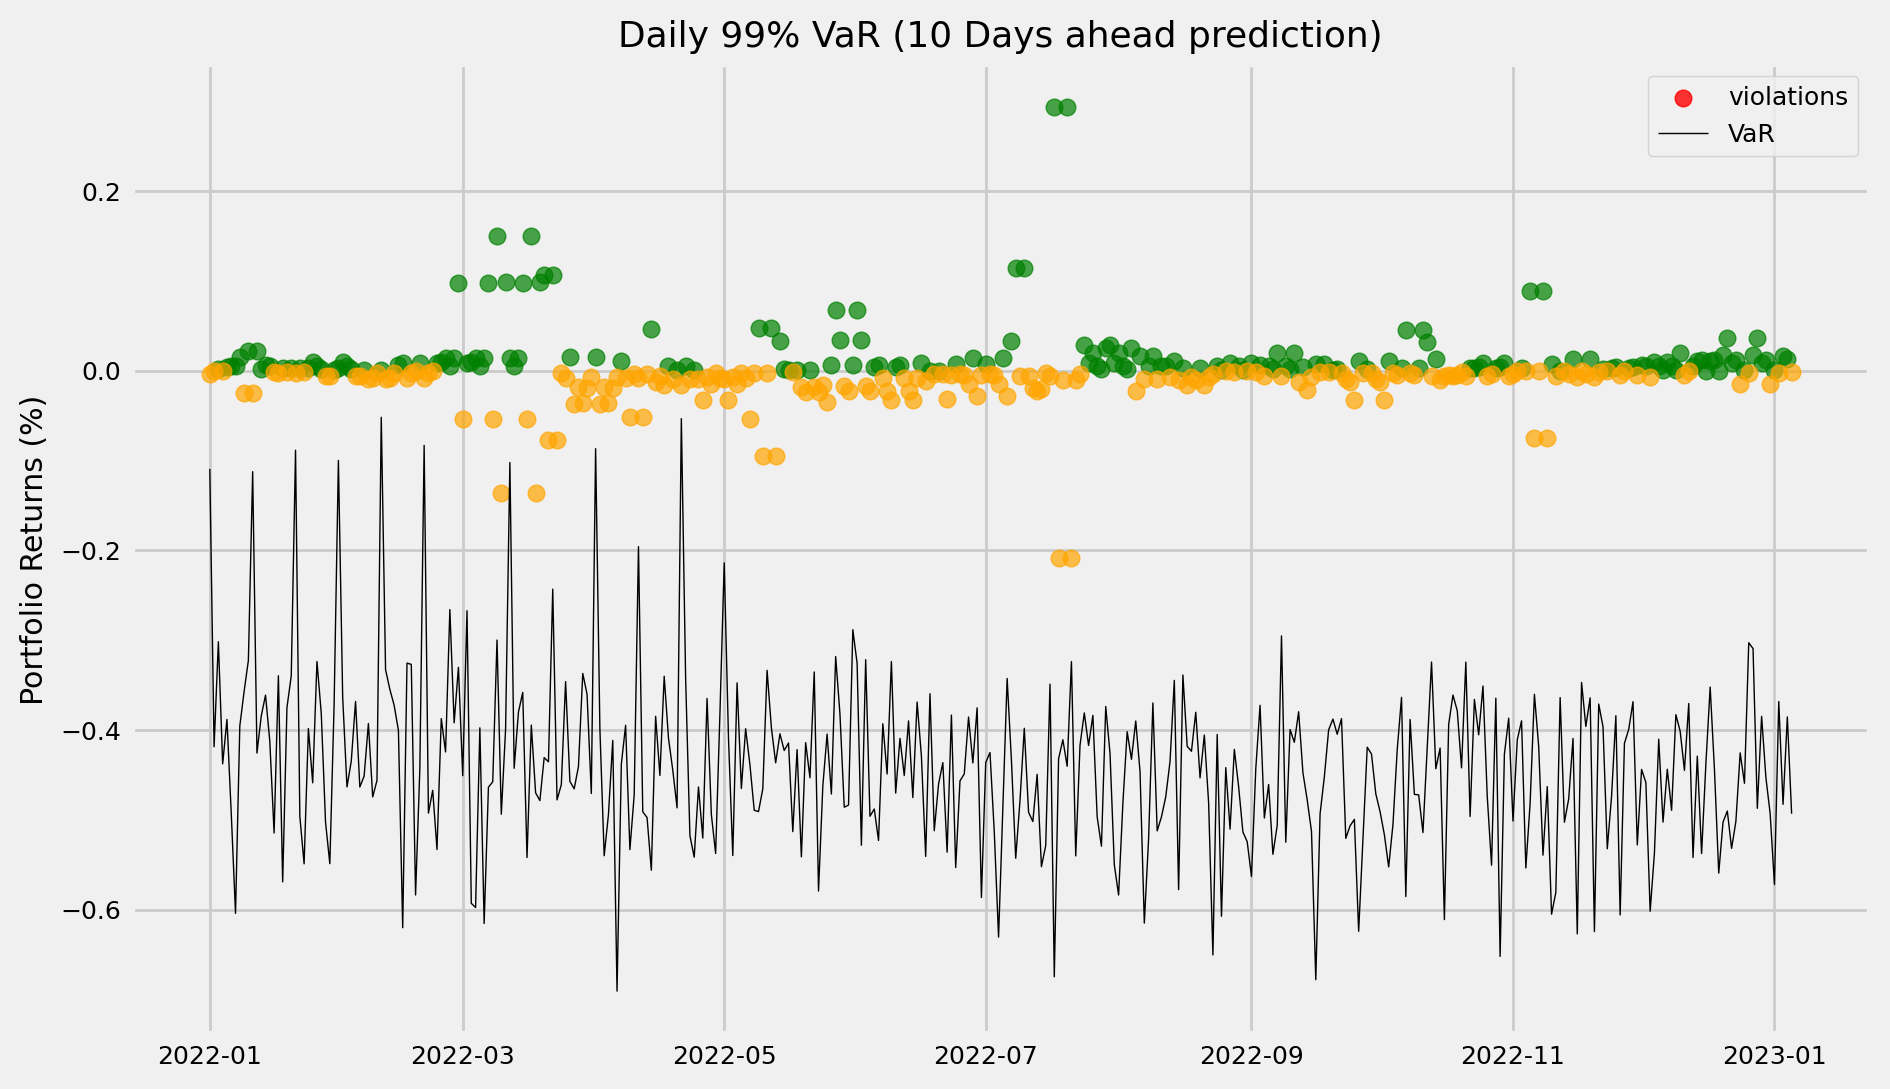

POF test p-value 0.22
IF test p-value 1.00
Число пробоев: 0


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
portf= fdf['Real']
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

fdf['Violation'] = (fdf['Real'] < fdf['VaR'])
breakdowns = fdf[fdf['Violation'] == 1]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.index, breakdowns.Real, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(fdf.index, fdf['VaR'], label = 'VaR', c = 'black')
plt.legend()
plt.title('Daily 99% VaR (10 Days ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show();

tests(fdf)
print('Число пробоев: {}'.format(fdf['Violation'].sum()))

In [ ]:
def train_and_predict(train_X, train_Y, test_X):
  num_equities = len(train_Y.columns)
  num_factors = len(train_X.columns)
  num_samples = test_X.shape[1]
  prediction_length = test_X.shape[-1]

  lr_predictions = np.zeros((num_equities, num_samples, prediction_length))

  for i, col in tqdm(enumerate(train_Y.columns)):
    lr = LinearRegression()
    lr = lr.fit(train_X, train_Y[col].values)
    for j in range(num_samples):
      sample_X = test_X[:,j,:].T
      pred_y = lr.predict(sample_X)
      lr_predictions[i,j,:] = pred_y

  return lr_predictions


In [ ]:
train_ends = pd.date_range('2022-01-01', '2022-12-30', freq='10D')

In [ ]:
n_samples = 100
window = 10

collector = []

for train_end_ in train_ends:
  train_end = train_end_.strftime('%Y-%m-%d')
  generated_rf = generate_riskfactors(riskfactor_df, 100, window, train_end, n_samples)
  generated_eq = train_and_predict(riskfactor_df, portfolio_df, generated_rf)

  pv = calc_pfvalue_ondate(final_portfolio_real, train_end)


  sim_equities = generated_eq.copy()
  sim_currency = generated_rf[3:,:,:].copy()

  portfolio_prices = np.vstack([sim_equities, sim_currency])

  assert portfolio_prices.shape[0] == 17


  weights = [1] * 10 + [10] * 5 + [100] * 2
  weights = (np.array(weights) / sum(weights)).reshape(-1, 1)


  pfd_sims = []

  for simulation_unit in range(portfolio_prices.shape[1]):
    one_simulation = portfolio_prices[:, simulation_unit, :]
    start_quantities = pv * weights.flatten() / one_simulation[:,0]

    portfolio_dynamics = []

    for time_unit in range(one_simulation.shape[-1]):
      portfolio_value = start_quantities * one_simulation[:, time_unit]

      start_quantities = portfolio_value.sum() * weights.flatten() / one_simulation[:, time_unit]
      portfolio_dynamics.append(portfolio_value)

    pfd_sims.append(portfolio_dynamics)

  pfd_sims = np.array(pfd_sims)
  pfd_sims = pfd_sims.transpose(2, 0, 1)
  portfolio_value_simulations = pfd_sims.sum(axis=0)
  log_returns = np.diff(np.log(portfolio_value_simulations), axis=1)

  var_99 = bigan_var(log_returns.dot(weights), 0.99, axis=0)

  train_end_extend = (train_end_.date() + pd.Timedelta(window-1, unit='d')).strftime('%Y-%m-%d')

  real = calc_pfvalue_ondate(final_portfolio_real, train_end_extend, False)
  real_logret = np.diff(np.log(real))[-(window-1):]

  c = []

  for i in range(log_returns.shape[0]):
    es = log_returns[i,:][log_returns[i,:] > var_99]
    es = list(es)
    c+= es

  ES = np.nanmean(c)

  collector.append((var_99, real_logret, ES))

In [ ]:
dates = []
vars = []
reals = []
ess = []

for i, te in enumerate(train_ends):
  cl = collector[i]
  daterange = pd.date_range(start=te, periods=cl[0].shape[0], freq='1D')
  dates.append(list(daterange))

  vars.append(list(cl[0]))
  reals.append(list(cl[1]))
  ess.append([cl[2]] * len(daterange))

dates = np.array(sum(dates, []))
vars = np.array(sum(vars, []))
reals = np.array(sum(reals, []))
ess = np.array(sum(ess, []))

In [ ]:
fdf_2 = pd.DataFrame({'Real': reals, 'VaR': -vars, 'ES': -ess}, index=dates)

In [ ]:
fdf_2['ES'] = fdf_2['ES'] -0.05

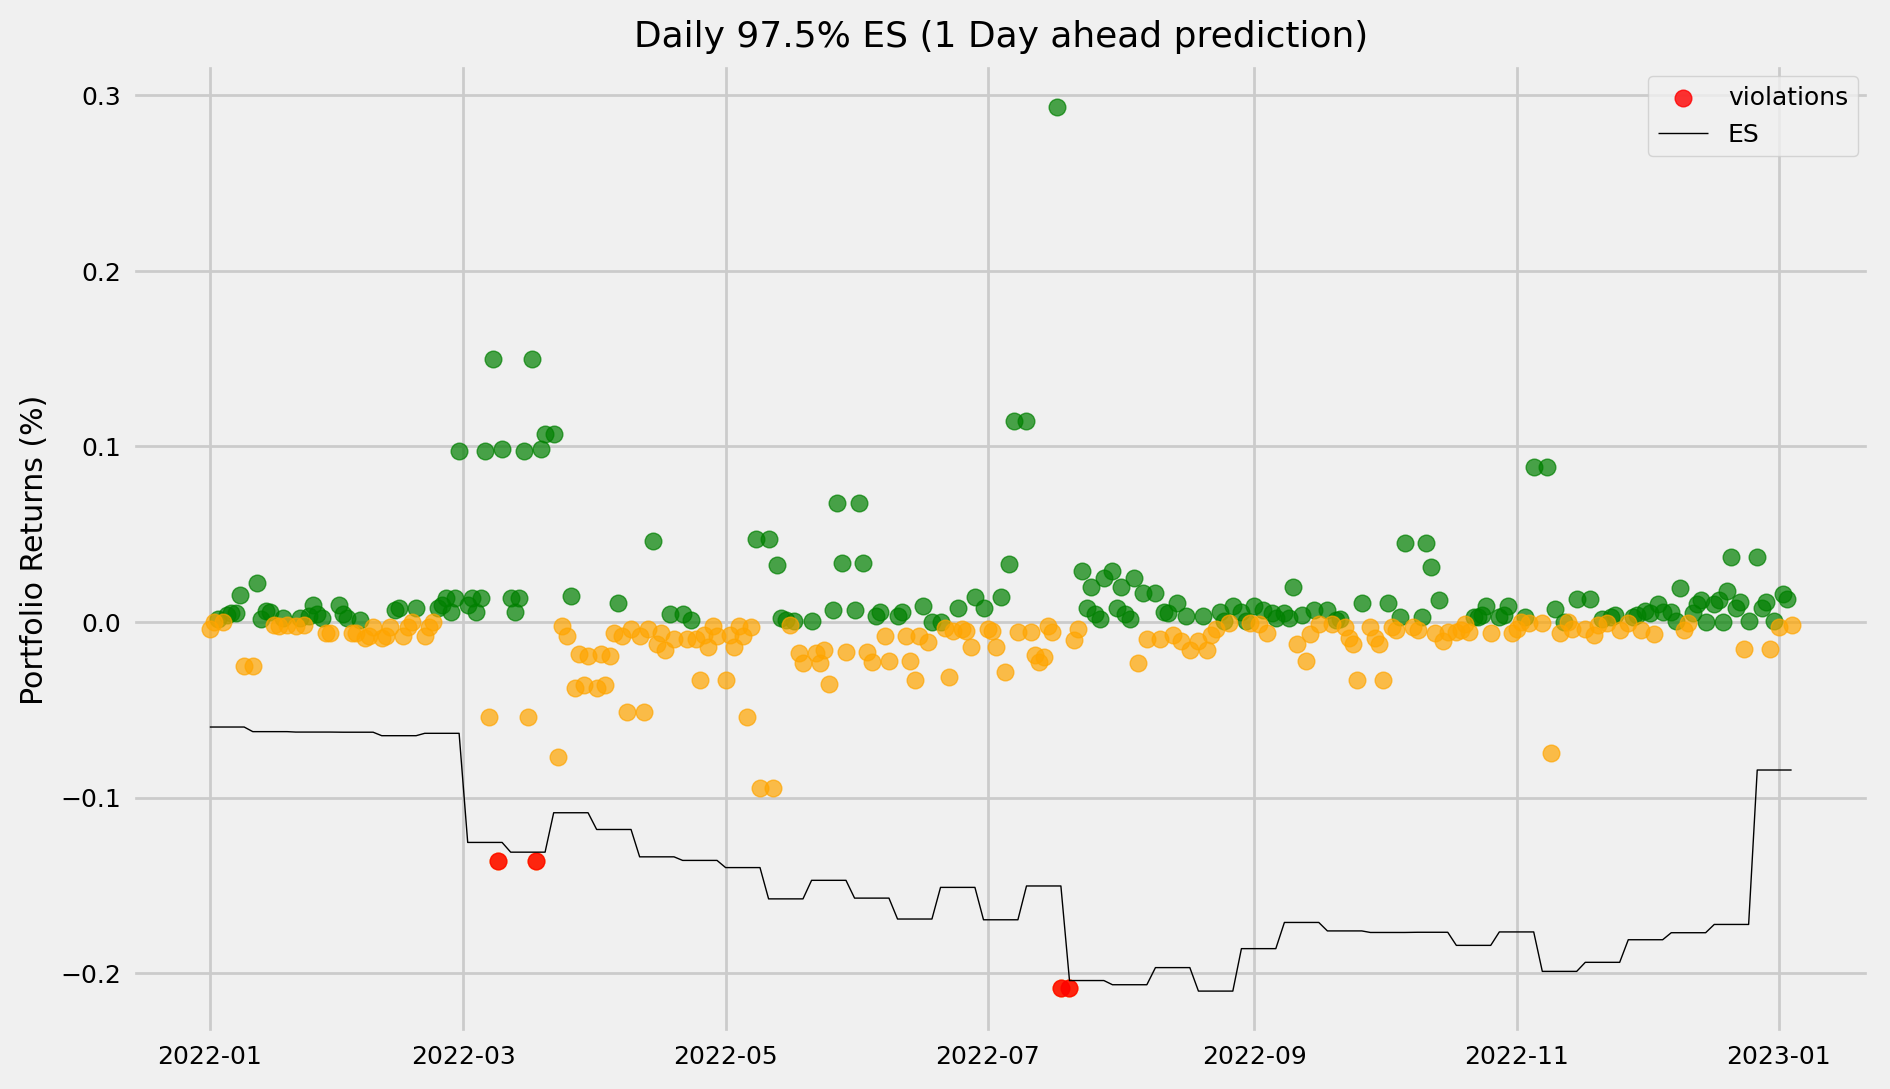

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
portf= fdf_2['Real']
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

fdf_2['Violation'] = (fdf_2['Real'] < fdf_2['ES'])
breakdowns = fdf_2[fdf_2['Violation'] == 1]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.index, breakdowns.Real, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(fdf_2.index, fdf_2['ES'], label = 'ES', c = 'black')
plt.legend()
plt.title('Daily 97.5% ES (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show();

In [ ]:
def tests(df):
    var = 'ES'
    print('POF test p-value',"%.2f" % pof_test(df[var], df['Real']))
    print('IF test p-value',"%.2f" % if_test(df[var], df['Real']))

In [ ]:
tests(fdf_2)
print('Число пробоев: {}'.format(fdf_2['Violation'].sum()))

POF test p-value 0.01
IF test p-value 0.03
Число пробоев: 4


In [ ]:
fdf_2['ES'] = fdf_2['ES'] * np.sqrt(10)

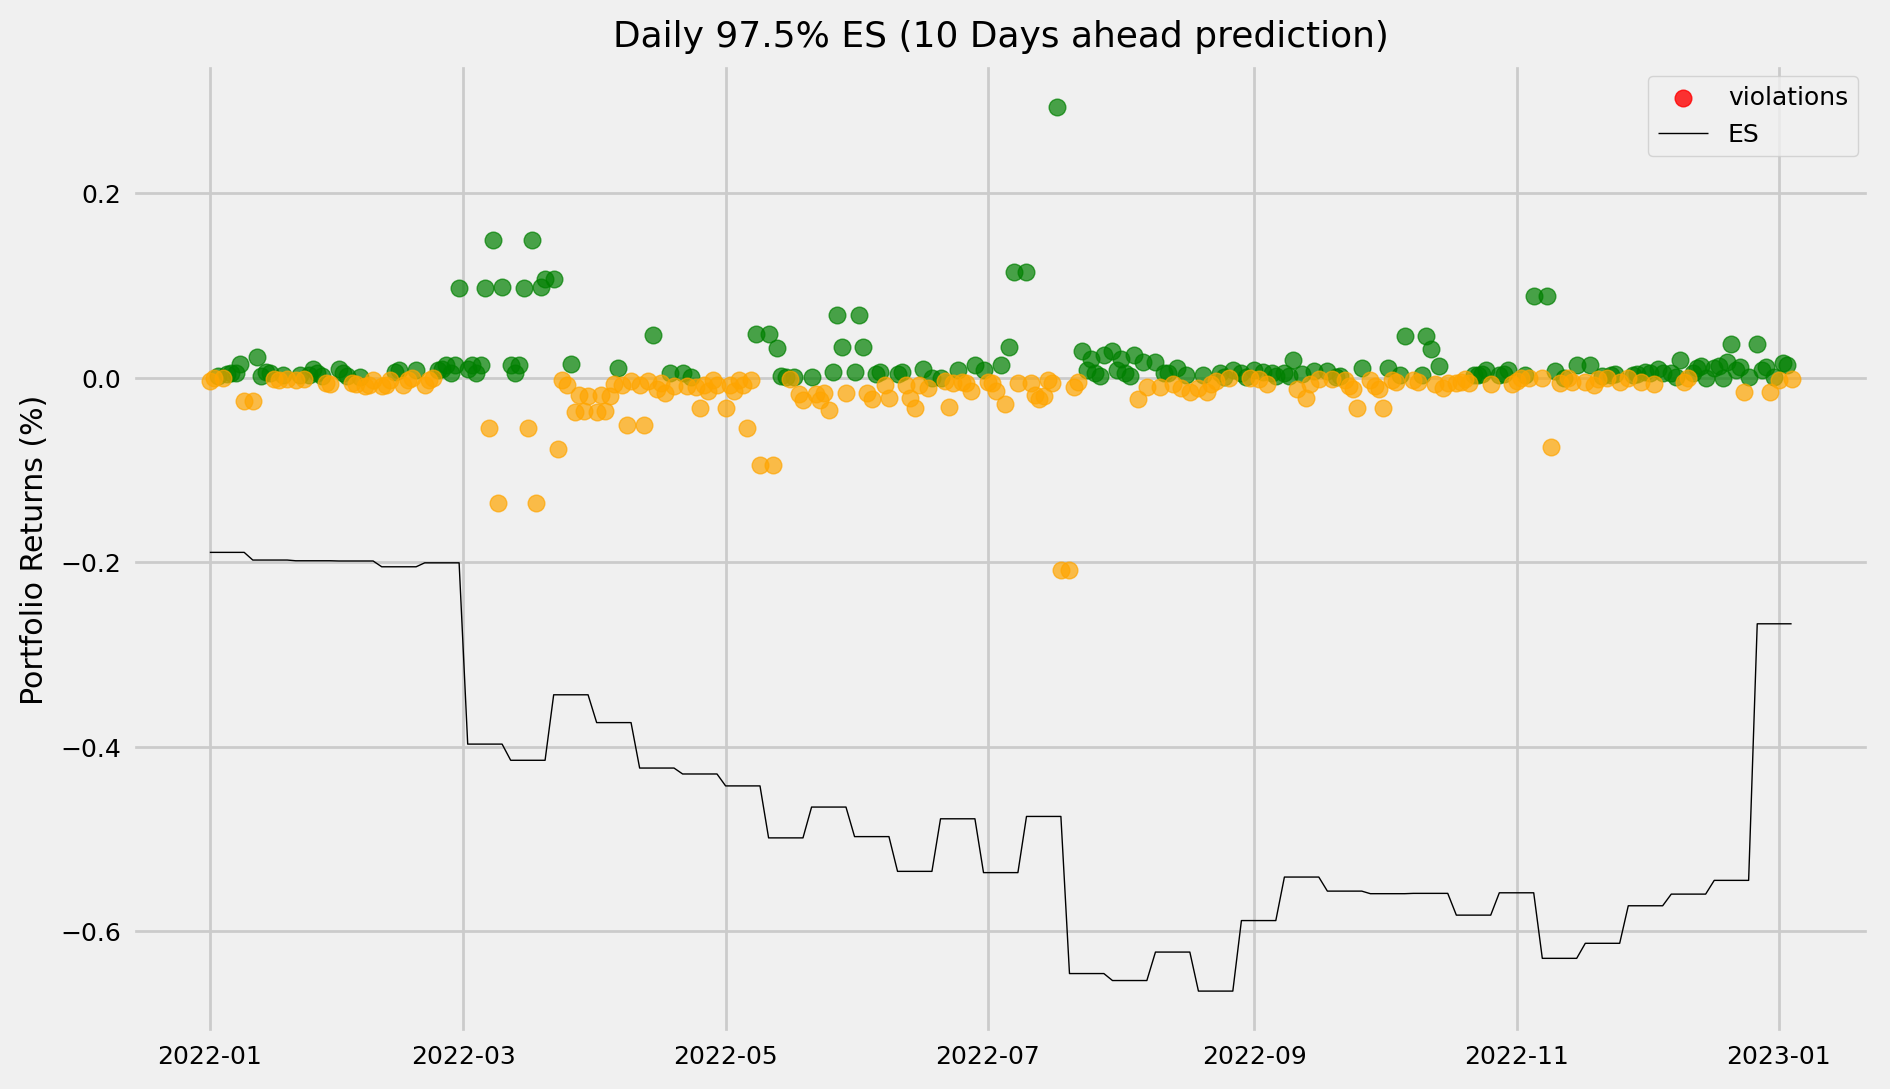

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
portf= fdf_2['Real']
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

fdf_2['Violation'] = (fdf_2['Real'] < fdf_2['ES'])
breakdowns = fdf_2[fdf_2['Violation'] == 1]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.index, breakdowns.Real, c = 'red', alpha = 0.8,  label = 'violations')
plt.plot(fdf_2.index, fdf_2['ES'], label = 'ES', c = 'black')
plt.legend()
plt.title('Daily 97.5% ES (10 Days ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show();

In [ ]:
def tests(df):
    var = 'ES'
    print('POF test p-value',"%.2f" % pof_test(df[var], df['Real']))
    print('IF test p-value',"%.2f" % if_test(df[var], df['Real']))

In [ ]:
tests(fdf_2)
print('Число пробоев: {}'.format(fdf_2['Violation'].sum()))

POF test p-value 0.25
IF test p-value 1.00
Число пробоев: 0
